In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import os
import numpy as np

# --- Data Preprocessing Functions (Identical to your original code) ---

def preprocess_data(data_path):
    df = pd.read_csv(data_path)
    
    # 고혈압(HE_HP2) 전처리
    def classify_bp(row):
        sbp = row['HE_sbp1']
        dbp = row['HE_dbp1']
        if pd.isna(sbp) or pd.isna(dbp):
            return np.nan
        if sbp >= 140 or dbp >= 90:
            return 4
        elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
            return 3
        elif 120 <= sbp <= 129 and dbp < 80:
            return 2
        elif 0 <= sbp < 120 and dbp < 80:
            return 1
    df['HE_HP2'] = df.apply(classify_bp, axis=1)
    df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')
    
    # 당뇨(HE_glu) 전처리
    def classify_diabetes(row):
        fglu = row['HE_glu']
        if pd.isna(fglu):
            return np.nan
        if fglu >= 126:
            return 3  # 당뇨
        elif 100 <= fglu < 126:
            return 2  # 공복혈당장애
        else:
            return 1  # 정상
    df['HE_DM'] = df.apply(classify_diabetes, axis=1)
    df['HE_DM'] = pd.to_numeric(df['HE_DM'], errors='coerce')
    
    # 비만(HE_BMI) 전처리
    def classify_bmi(row):
        bmi = row['HE_BMI']
        if bmi <= 18.5:
            return 1
        elif 18.5 < bmi <= 22.9:
            return 2
        elif 22.9 < bmi <= 24.9:
            return 3
        elif 24.9 < bmi <= 29.9:
            return 4
        elif 29.9 < bmi <= 34.9:
            return 5
        else:
            return 6
    df['HE_BMI_class'] = df.apply(classify_bmi, axis=1)
    df['HE_BMI_class'] = pd.to_numeric(df['HE_BMI_class'], errors='coerce')
    
    # 생활습관 변수 전처리
    df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
        '1.0': 0, '2.0': 1, '3.0': 2, '4.0': 3, '5.0': 4, '6.0': 5,
        '7.0': 6, '8.0': 7, '88.0': 0, '99.0': np.nan, 'nan': np.nan
    })
    df['BE3_31'] = pd.to_numeric(df['BE3_31'], errors='coerce')
    
    df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({
        '1.0': 1095, '2.0': 730, '3.0': 365, '4.0': 286, '5.0': 156,
        '6.0': 52, '7.0': 30, '8.0': 12, '9.0': 6, '99.0': np.nan, 'nan': np.nan
    })
    df['LS_VEG1'] = pd.to_numeric(df['LS_VEG1'], errors='coerce')
    
    df['BS3_2'] = df['BS3_2'].replace(888, 0)
    df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan})
    df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
    df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')
    df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)
    df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({'999.0': np.nan})
    df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')
    
    df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({
        '1.0': 0, '2.0': 6, '3.0': 12, '4.0': 42, '5.0': 130, '6.0': 286,
        '8.0': 0, '9.0': np.nan, 'nan': np.nan
    })
    df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')
    
    return df

# --- Main training and saving logic ---

def train_and_save_scalers(data_path="건강데이터_2022_2023_합본.csv", scaler_filepath="scalers.pkl"):
    """
    데이터를 전처리하고, 각 질병 그룹별 StandardScaler를 학습하여 PKL 파일로 저장합니다.
    """
    print("🚀 스케일러 학습 및 저장 프로세스를 시작합니다.")
    df = preprocess_data(data_path)
    selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'LS_VEG1']
    scalers = {}

    disease_configs = [
        ('hypertension', 'HE_HP2'),
        ('diabetes', 'HE_DM'),
        ('obesity', 'HE_BMI_class')
    ]

    for disease, col in disease_configs:
        for group_int in sorted(df[col].dropna().unique()):
            group_int = int(group_int)
            hp_df = df[df[col] == group_int][selected_cols].copy()
            
            if hp_df.empty:
                print(f"⚠️ 경고: '{disease}' 그룹 {group_int}에 데이터가 부족하여 스케일러를 학습할 수 없습니다.")
                continue
            
            # 결측치 처리 (mode imputation)
            for c in selected_cols:
                if hp_df[c].isnull().any():
                    mode_value = hp_df[c].mode(dropna=True)
                    hp_df[c].fillna(mode_value[0] if not mode_value.empty else 0, inplace=True)
            
            scaler = StandardScaler()
            scaler.fit(hp_df[selected_cols])
            scalers[(disease, group_int)] = scaler
            print(f"✅ 스케일러 학습 완료: '{disease}' - 그룹 {group_int}")

    # 학습된 스케일러 저장
    try:
        with open(scaler_filepath, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"🎉 모든 스케일러가 '{scaler_filepath}'에 성공적으로 저장되었습니다.")
    except Exception as e:
        print(f"❌ 스케일러 저장 중 오류 발생: {e}")

if __name__ == "__main__":
    train_and_save_scalers()

🚀 스케일러 학습 및 저장 프로세스를 시작합니다.
✅ 스케일러 학습 완료: 'hypertension' - 그룹 1
✅ 스케일러 학습 완료: 'hypertension' - 그룹 2
✅ 스케일러 학습 완료: 'hypertension' - 그룹 3
✅ 스케일러 학습 완료: 'hypertension' - 그룹 4
✅ 스케일러 학습 완료: 'diabetes' - 그룹 1
✅ 스케일러 학습 완료: 'diabetes' - 그룹 2
✅ 스케일러 학습 완료: 'diabetes' - 그룹 3
✅ 스케일러 학습 완료: 'obesity' - 그룹 1
✅ 스케일러 학습 완료: 'obesity' - 그룹 2
✅ 스케일러 학습 완료: 'obesity' - 그룹 3
✅ 스케일러 학습 완료: 'obesity' - 그룹 4
✅ 스케일러 학습 완료: 'obesity' - 그룹 5
✅ 스케일러 학습 완료: 'obesity' - 그룹 6
🎉 모든 스케일러가 'scalers.pkl'에 성공적으로 저장되었습니다.


C:\Users\asia\AppData\Local\Temp\ipykernel_6820\1167443526.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['BE3_31'] = df['BE3_31'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_6820\1167443526.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({
C:\Users\asia\AppData\Local\Temp\ipykernel_6820\1167443526.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the ol

✅ 스케일러 파일 'scalers.pkl'을(를) 로드합니다.
사용자의 건강 및 생활습관 수치를 입력해주세요.

--- 홍길동님의 hypertension 상태: 고혈압 전단계 (그룹 3) ---
생활습관을 고려했을 때 고혈압 전단계 그룹의 4번 군집에 속합니다.
| 항목                                     |   홍길동님 수치 |   군집 4 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            4.00 |               5.50 |
| 하루 평균 흡연량                         |            3.00 |               5.35 |
| 1주일 간 걷기 일수                       |            3.00 |               4.20 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            2.00 |               2.35 |


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


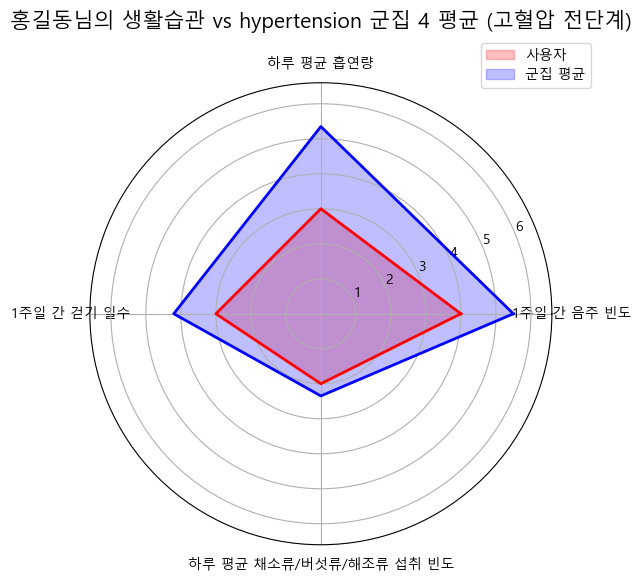


--- 홍길동님의 diabetes 상태: 정상 (그룹 1) ---
생활습관을 고려했을 때 정상 그룹의 4번 군집에 속합니다.
| 항목                                     |   홍길동님 수치 |   군집 4 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            4.00 |               5.50 |
| 하루 평균 흡연량                         |            3.00 |               5.62 |
| 1주일 간 걷기 일수                       |            3.00 |               3.54 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            2.00 |               2.21 |


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


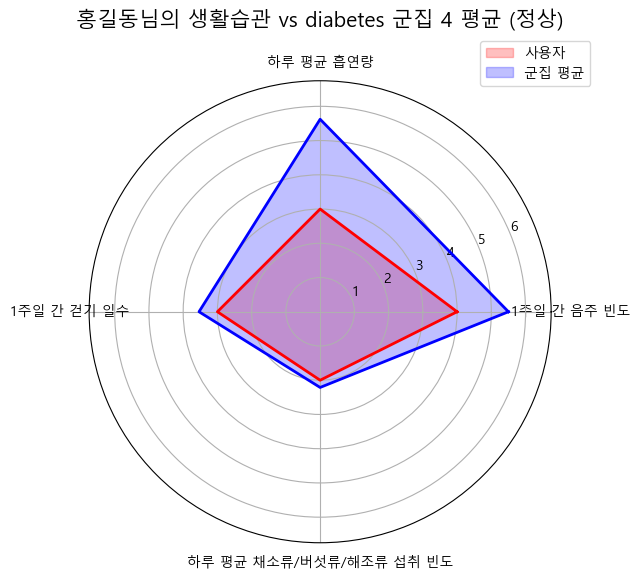


--- 홍길동님의 obesity 상태: 비만 (그룹 4) ---
생활습관을 고려했을 때 비만 그룹의 5번 군집에 속합니다.
| 항목                                     |   홍길동님 수치 |   군집 5 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            4.00 |               5.50 |
| 하루 평균 흡연량                         |            3.00 |               3.82 |
| 1주일 간 걷기 일수                       |            3.00 |               3.64 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            2.00 |               2.36 |


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


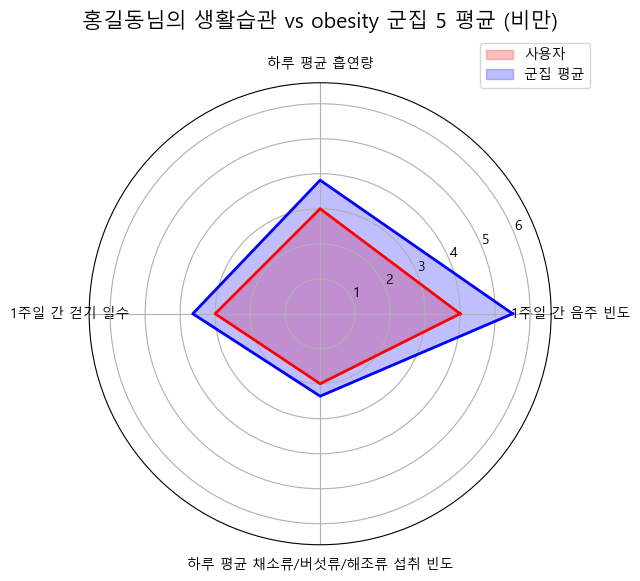

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import pickle
import os

# matplotlib 한글 설정 (필요시 이 파일에도 포함)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- Precalculated Cluster Means (Identical to your original code) ---
# 이 부분은 'train_and_save_scalers.py'와 'run_health_comparison.py'
# 양쪽에 모두 필요합니다.
HE_HP_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.167185, 0.239176, 3.172158, 1.363797, 0.304851, 0.318776, 0.126048],
        '하루 평균 흡연량': [0.321646, 0.312566, 2.000000, 20.489297, 0.751894, 0.548831, 0.317757],
        '1주일 간 걷기 일수': [0.863567, 6.208025, 4.344316, 3.593272, 2.034091, 6.138927, 0.781931],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.000000, 3.000000, 2.163088, 2.080349, 0.895143, 1.871035, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.284722, 2.500000, 0.858974, 0.150502, 0.221657, 5.500000, 0.165176],
        '하루 평균 흡연량': [0.633333, 1.149606, 19.418803, 0.337793, 0.470769, 4.475000, 0.191214],
        '1주일 간 걷기 일수': [6.180556, 4.299213, 3.709402, 1.187291, 1.098462, 4.075000, 6.297158],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.796187, 2.448819, 2.183140, 3.000000, 1.785248, 2.387500, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.763355, 0.468248, 1.676724, 0.647671, 5.500000, 0.515860, 0.553569],
        '하루 평균 흡연량': [1.145833, 0.461916, 19.193966, 0.774869, 5.348837, 0.309278, 0.989384],
        '1주일 간 걷기 일수': [5.069444, 1.302211, 3.288793, 6.057592, 4.203488, 6.268041, 1.171975],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [0.925590, 3.000000, 2.207806, 2.000000, 2.347993, 3.000000, 1.914155]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [2.756947, 0.653964, 5.500000, 0.479380, 0.589461, 0.454250],
        '하루 평균 흡연량': [20.293194, 0.917178, 2.215827, 0.298479, 0.627753, 0.253644],
        '1주일 간 걷기 일수': [3.701571, 1.303681, 3.856115, 6.292776, 6.162996, 1.192420],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.301771, 1.801597, 2.403903, 3.000000, 1.854179, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

HE_DM_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.150946, 0.372085, 1.158756, 0.228997, 5.500000, 2.500000, 0.237966],
        '하루 평균 흡연량': [0.323770, 0.541776, 19.725768, 0.288396, 5.622449, 1.360502, 0.423890],
        '1주일 간 걷기 일수': [0.927049, 5.964267, 2.933806, 6.161263, 3.537415, 3.819749, 0.981501],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.771406, 2.114544, 3.000000, 2.211099, 2.249319, 1.774280]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.512626, 0.579406, 5.500000, 1.479076, 0.455288, 0.619097],
        '하루 평균 흡연량': [0.431724, 0.700143, 5.978166, 18.295597, 0.309375, 0.690799],
        '1주일 간 걷기 일수': [6.137931, 0.982783, 3.187773, 2.732704, 1.046875, 6.037707],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.842255, 2.362445, 2.143043, 3.000000, 1.812732]
    }, index=[0, 1, 2, 3, 4, 5]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.145881, 0.142308, 0.546853, 1.466873, 5.500000, 0.098474],
        '하루 평균 흡연량': [0.161702, 0.342857, 0.309091, 20.496350, 6.471264, 0.170241],
        '1주일 간 걷기 일수': [0.331915, 1.023810, 5.949495, 2.905109, 2.977011, 0.239946],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 0.886941, 2.630303, 2.296130, 2.390805, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

obe_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.041231, 0.499675, 0.140793, 4.500000, 0.955301, 0.043403],
        '하루 평균 흡연량': [0.000000, 0.253165, 0.078788, 7.933333, 17.162162, 0.046875],
        '1주일 간 걷기 일수': [0.144033, 5.886076, 0.454545, 2.766667, 3.513514, 0.138889],
        '하루 평균 채소 섭취 빈도': [3.000000, 2.239894, 0.892453, 2.080913, 2.135061, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [1.437870, 0.338664, 0.565225, 0.397819, 5.500000],
        '하루 평균 흡연량': [16.953177, 0.164277, 0.426172, 0.364297, 7.000000],
        '1주일 간 걷기 일수': [2.856187, 3.597969, 6.012378, 0.932149, 3.066327],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.208769, 3.000000, 1.795531, 1.804506, 2.276950]
    }, index=[0, 1, 2, 3, 4]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.378722, 0.526020, 0.595941, 5.500000, 1.447802, 0.462214],
        '하루 평균 흡연량': [0.326613, 0.415435, 0.581359, 4.986486, 19.017857, 0.407733],
        '1주일 간 걷기 일수': [0.987903, 0.957307, 5.990521, 3.567568, 2.852679, 6.130053],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.779103, 1.809968, 2.371122, 2.212353, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [0.519089, 0.550410, 2.104251, 0.601160, 0.417795, 5.500000, 1.564362],
        '하루 평균 흡연량': [0.609069, 0.366864, 34.342105, 0.599757, 0.407108, 3.816667, 16.915825],
        '1주일 간 걷기 일수': [1.055147, 6.143491, 3.000000, 5.928224, 1.080775, 3.638889, 2.787879],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.812550, 3.000000, 2.289474, 1.808696, 3.000000, 2.355556, 2.102071]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    5: pd.DataFrame({
        '1주일 간 음주 빈도': [0.172308, 0.832751, 0.241978, 5.500000, 2.500000, 0.380881, 0.341026],
        '하루 평균 흡연량': [0.200000, 21.196970, 0.914286, 4.147059, 1.562500, 0.330097, 1.216667],
        '1주일 간 걷기 일수': [5.973333, 3.090909, 5.062857, 3.323529, 4.734375, 0.961165, 0.550000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.890619, 1.764055, 2.189041, 2.069178, 3.000000, 1.813014]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    6: pd.DataFrame({
        '1주일 간 음주 빈도': [0.175570, 0.255583, 2.500000, 0.225175, 5.500000, 0.913462],
        '하루 평균 흡연량': [0.064815, 0.655914, 5.400000, 0.345455, 9.466667, 22.350000],
        '1주일 간 걷기 일수': [0.435185, 6.139785, 5.466667, 0.563636, 3.133333, 2.400000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 2.174311, 2.333333, 1.796090, 2.228493, 2.042740]
    }, index=[0, 1, 2, 3, 4, 5])
}

# --- Functions for user input, disease determination, cluster determination, and plotting ---

def get_user_input():
    print("사용자의 건강 및 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    sbp = float(input("수축기 혈압 (mmHg): "))
    dbp = float(input("이완기 혈압 (mmHg): "))
    fglu = float(input("공복혈당 (mg/dL): "))
    bmi = float(input("BMI (kg/m²): "))
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (회): "))
    daily_veg = float(input("하루 평균 채소류/버섯류/해조류 섭취 빈도 (회/일): "))
    return name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg

def determine_disease_groups(sbp, dbp, fglu, bmi):
    # 고혈압
    if sbp >= 140 or dbp >= 90:
        he_hp2 = 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        he_hp2 = 3
    elif 120 <= sbp <= 129 and dbp < 80:
        he_hp2 = 2
    else:
        he_hp2 = 1
    
    # 당뇨
    if fglu >= 126:
        he_dm = 3
    elif 100 <= fglu < 126:
        he_dm = 2
    else:
        he_dm = 1
    
    # 비만
    if bmi <= 18.5:
        he_bmi = 1
    elif 18.5 < bmi <= 22.9:
        he_bmi = 2
    elif 22.9 < bmi <= 24.9:
        he_bmi = 3
    elif 24.9 < bmi <= 29.9:
        he_bmi = 4
    elif 29.9 < bmi <= 34.9:
        he_bmi = 5
    else:
        he_bmi = 6
    
    return he_hp2, he_dm, he_bmi

def determine_cluster_with_precalculated_means(user_data_weekly_daily, group, disease, scaler, precalculated_means_dict, selected_cols):
    group_int = int(group)
    if group_int not in precalculated_means_dict:
        print(f"{disease} 그룹 {group_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return None, None
    
    cluster_means_precalculated_text_names = precalculated_means_dict[group_int].copy()
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': 'LS_VEG1'
    }
    
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)
        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            print(f"경고: {disease}의 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 데이터에 없습니다.")
            return None, None
    
    if cluster_means_precalculated_internal_names.isnull().values.any():
        print(f"경고: {disease}의 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")
        return None, None
    
    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols])
    
    user_data_transformed = [
        user_data_weekly_daily[0] * 52,  # 연간 음주
        user_data_weekly_daily[1],       # 하루 흡연
        user_data_weekly_daily[2],       # 주간 걷기
        user_data_weekly_daily[3] * 365  # 연간 채소
    ]
    
    user_data_scaled = scaler.transform([user_data_transformed])
    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled, axis=1)
    closest_cluster = np.argmin(distances)
    cluster_means = precalculated_means_dict[group_int].iloc[closest_cluster]
    
    return closest_cluster, cluster_means

def plot_radar_chart(user_data, cluster_mean, categories, title):
    values_user = user_data[:]
    values_cluster = cluster_mean[:]
    all_values = values_user + values_cluster
    max_val = max(all_values) if all_values else 1
    
    values_user = values_user + values_user[:1]
    values_cluster = values_cluster + values_cluster[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max_val * 1.2)
    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

# --- Main comparison logic ---

def run_health_comparison(scaler_filepath="scalers.pkl"):
    """
    저장된 스케일러를 로드하고 사용자 입력을 받아 건강 비교를 수행합니다.
    """
    selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'LS_VEG1']
    item_names = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '하루 평균 채소류/버섯류/해조류 섭취 빈도']
    
    scalers = {}
    
    # 스케일러 로드 시도
    if os.path.exists(scaler_filepath):
        print(f"✅ 스케일러 파일 '{scaler_filepath}'을(를) 로드합니다.")
        try:
            with open(scaler_filepath, 'rb') as f:
                scalers = pickle.load(f)
        except Exception as e:
            print(f"❌ 스케일러 로드 중 오류 발생: {e}. 'train_and_save_scalers.py'를 다시 실행해야 할 수 있습니다.")
            return # 오류 발생 시 종료
    else:
        print(f"❌ 스케일러 파일 '{scaler_filepath}'이(가) 존재하지 않습니다. 먼저 'train_and_save_scalers.py'를 실행하여 스케일러를 생성해주세요.")
        return # 파일 없으면 종료

    # 사용자 입력 받기
    name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg = get_user_input()
    he_hp2, he_dm, he_bmi = determine_disease_groups(sbp, dbp, fglu, bmi)
    
    disease_labels = {
        'hypertension': {1: "정상 혈압", 2: "주의 혈압", 3: "고혈압 전단계", 4: "고혈압"},
        'diabetes': {1: "정상", 2: "당뇨 전단계", 3: "당뇨"},
        'obesity': {1: "저체중", 2: "정상 체중", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
    }
    
    diseases = [
        ('hypertension', he_hp2, HE_HP_precalculated_means, 'HE_HP2'),
        ('diabetes', he_dm, HE_DM_precalculated_means, 'HE_DM'),
        ('obesity', he_bmi, obe_precalculated_means, 'HE_BMI_class')
    ]
    
    user_data = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
    
    for disease, group, precalculated_means, col in diseases:
        group_int = int(group)
        print(f"\n--- {name}님의 {disease} 상태: {disease_labels[disease][group_int]} (그룹 {group_int}) ---")
        
        # 해당 그룹의 스케일러 로드
        scaler_key = (disease, group_int)
        if scaler_key not in scalers:
            print(f"오류: {disease} 그룹 {group_int}에 대한 스케일러가 로드되지 않았습니다. 'train_and_save_scalers.py'를 다시 실행해야 합니다.")
            continue # 다음 질병으로 넘어감
        
        current_scaler = scalers[scaler_key]
        
        cluster, cluster_means = determine_cluster_with_precalculated_means(
            user_data, group_int, disease, current_scaler, precalculated_means, selected_cols
        )
        
        if cluster is not None:
            print(f"생활습관을 고려했을 때 {disease_labels[disease][group_int]} 그룹의 {cluster}번 군집에 속합니다.")
            
            table_data = {
                '항목': item_names,
                f'{name}님 수치': user_data,
                f'군집 {cluster} 평균 수치': cluster_means.tolist()
            }
            comparison_df = pd.DataFrame(table_data)
            print(comparison_df.to_markdown(index=False, floatfmt=".2f"))
            
            plot_radar_chart(
                user_data,
                cluster_means.tolist(),
                item_names,
                f"{name}님의 생활습관 vs {disease} 군집 {cluster} 평균 ({disease_labels[disease][group_int]})"
            )

if __name__ == "__main__":
    run_health_comparison()

✅ 스케일러 파일 'scalers.pkl'을(를) 로드합니다.
사용자의 건강 및 생활습관 수치를 입력해주세요.

--- 홍길동님의 hypertension 상태: 고혈압 (그룹 4) ---
생활습관을 고려했을 때 고혈압 그룹의 2번 군집에 속합니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


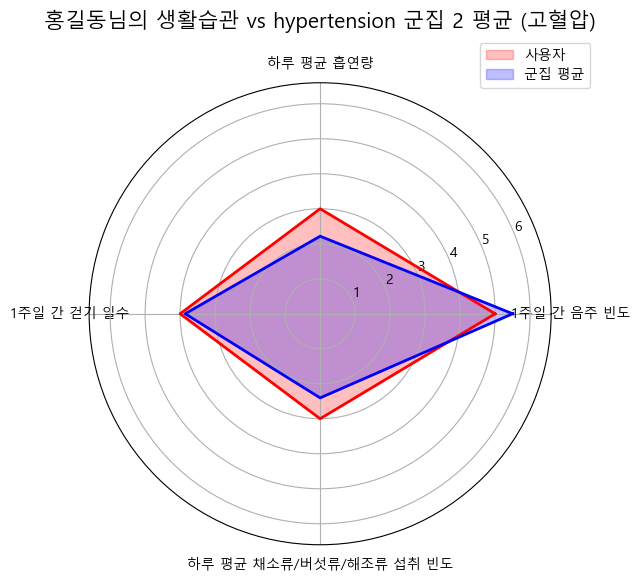


--- 생활 습관 비교 ---
| 항목                                     |   홍길동님 수치 |   군집 2 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            5.00 |               5.50 |
| 하루 평균 흡연량                         |            3.00 |               2.22 |
| 1주일 간 걷기 일수                       |            4.00 |               3.86 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            3.00 |               2.40 |

--- 생활습관 정보 ---
흡연
현재 19세 이상 흡연율은 19.6%입니다.
전체 인구의 하루 평균 흡연량은 약 2.57개비 입니다.

걷기
WHO는 주당 최소 150~300분의 중강도 유산소 활동 또는 75~150분의 고강도 유산소 활동을 권장합니다.
이는 하루 30분씩 주 5일 이상 활동하는 것을 의미합니다.

채소
WHO는 하루 총 400g 이상의 채소류 섭취를 권장합니다.
채소류, 해조류, 버섯류를 모두 식사에 포함한다면 1끼당 100~150g의 섭취가 가능합니다.

음주
주간 음주율은 다음과 같습니다.
[주 2~3회: 13.4%] [주 4~5회: 3.3%] [6회 이상: 2.1%]

--- 개인화된 생활습관 분석 ---
군집 평균(2.22개비)에 비해 흡연량(3.00개비)이 많으므로 주의가 필요합니다.
군집 평균(5.50회)보다 음주 빈도(5.00회)가 적습니다. 좋은 습관입니다.
군집 평균(3.86일)보다 걷기 일수(4.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.40회/일)보다 채소류 섭취 빈도(3.00회/

c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


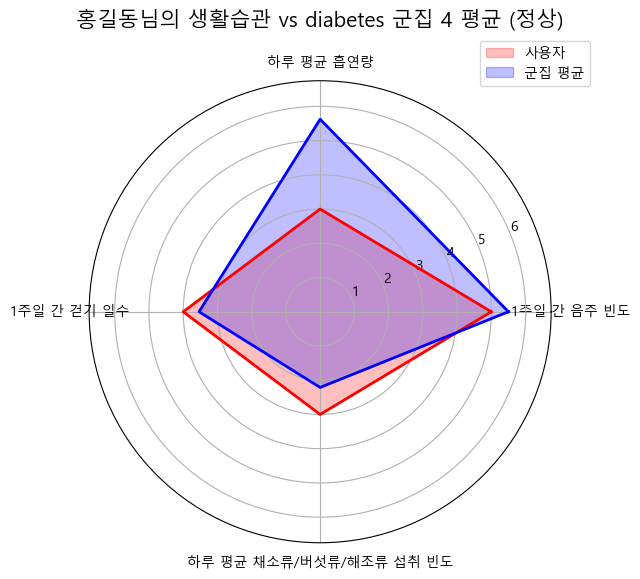


--- 생활 습관 비교 ---
| 항목                                     |   홍길동님 수치 |   군집 4 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            5.00 |               5.50 |
| 하루 평균 흡연량                         |            3.00 |               5.62 |
| 1주일 간 걷기 일수                       |            4.00 |               3.54 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            3.00 |               2.21 |

--- 생활습관 정보 ---
흡연
현재 19세 이상 흡연율은 19.6%입니다.
전체 인구의 하루 평균 흡연량은 약 2.57개비 입니다.

걷기
WHO는 주당 최소 150~300분의 중강도 유산소 활동 또는 75~150분의 고강도 유산소 활동을 권장합니다.
이는 하루 30분씩 주 5일 이상 활동하는 것을 의미합니다.

채소
WHO는 하루 총 400g 이상의 채소류 섭취를 권장합니다.
채소류, 해조류, 버섯류를 모두 식사에 포함한다면 1끼당 100~150g의 섭취가 가능합니다.

음주
주간 음주율은 다음과 같습니다.
[주 2~3회: 13.4%] [주 4~5회: 3.3%] [6회 이상: 2.1%]

--- 개인화된 생활습관 분석 ---
군집 평균(5.62개비)보다 흡연량(3.00개비)이 적습니다. 좋은 습관입니다.
군집 평균(5.50회)보다 음주 빈도(5.00회)가 적습니다. 좋은 습관입니다.
군집 평균(3.54일)보다 걷기 일수(4.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.21회/일)보다 채소류 섭취 빈도(3.00회/일)

c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


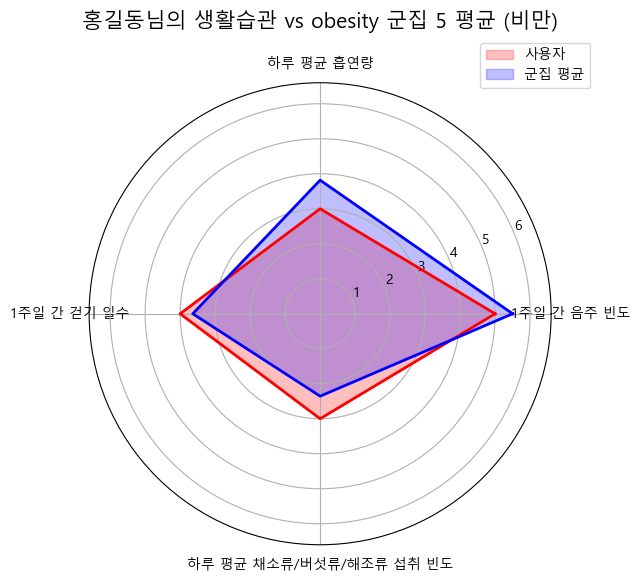


--- 생활 습관 비교 ---
| 항목                                     |   홍길동님 수치 |   군집 5 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            5.00 |               5.50 |
| 하루 평균 흡연량                         |            3.00 |               3.82 |
| 1주일 간 걷기 일수                       |            4.00 |               3.64 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            3.00 |               2.36 |

--- 생활습관 정보 ---
흡연
현재 19세 이상 흡연율은 19.6%입니다.
전체 인구의 하루 평균 흡연량은 약 2.57개비 입니다.

걷기
WHO는 주당 최소 150~300분의 중강도 유산소 활동 또는 75~150분의 고강도 유산소 활동을 권장합니다.
이는 하루 30분씩 주 5일 이상 활동하는 것을 의미합니다.

채소
WHO는 하루 총 400g 이상의 채소류 섭취를 권장합니다.
채소류, 해조류, 버섯류를 모두 식사에 포함한다면 1끼당 100~150g의 섭취가 가능합니다.

음주
주간 음주율은 다음과 같습니다.
[주 2~3회: 13.4%] [주 4~5회: 3.3%] [6회 이상: 2.1%]

--- 개인화된 생활습관 분석 ---
군집 평균(3.82개비)보다 흡연량(3.00개비)이 적습니다. 좋은 습관입니다.
군집 평균(5.50회)보다 음주 빈도(5.00회)가 적습니다. 좋은 습관입니다.
군집 평균(3.64일)보다 걷기 일수(4.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.36회/일)보다 채소류 섭취 빈도(3.00회/일)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import pickle
import os

# matplotlib 한글 설정 (필요시 이 파일에도 포함)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- Precalculated Cluster Means (Identical to your original code) ---
# 이 부분은 'train_and_save_scalers.py'와 'run_health_comparison.py'
# 양쪽에 모두 필요합니다.
HE_HP_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.167185, 0.239176, 3.172158, 1.363797, 0.304851, 0.318776, 0.126048],
        '하루 평균 흡연량': [0.321646, 0.312566, 2.000000, 20.489297, 0.751894, 0.548831, 0.317757],
        '1주일 간 걷기 일수': [0.863567, 6.208025, 4.344316, 3.593272, 2.034091, 6.138927, 0.781931],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.000000, 3.000000, 2.163088, 2.080349, 0.895143, 1.871035, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.284722, 2.500000, 0.858974, 0.150502, 0.221657, 5.500000, 0.165176],
        '하루 평균 흡연량': [0.633333, 1.149606, 19.418803, 0.337793, 0.470769, 4.475000, 0.191214],
        '1주일 간 걷기 일수': [6.180556, 4.299213, 3.709402, 1.187291, 1.098462, 4.075000, 6.297158],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.796187, 2.448819, 2.183140, 3.000000, 1.785248, 2.387500, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.763355, 0.468248, 1.676724, 0.647671, 5.500000, 0.515860, 0.553569],
        '하루 평균 흡연량': [1.145833, 0.461916, 19.193966, 0.774869, 5.348837, 0.309278, 0.989384],
        '1주일 간 걷기 일수': [5.069444, 1.302211, 3.288793, 6.057592, 4.203488, 6.268041, 1.171975],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [0.925590, 3.000000, 2.207806, 2.000000, 2.347993, 3.000000, 1.914155]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [2.756947, 0.653964, 5.500000, 0.479380, 0.589461, 0.454250],
        '하루 평균 흡연량': [20.293194, 0.917178, 2.215827, 0.298479, 0.627753, 0.253644],
        '1주일 간 걷기 일수': [3.701571, 1.303681, 3.856115, 6.292776, 6.162996, 1.192420],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.301771, 1.801597, 2.403903, 3.000000, 1.854179, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

HE_DM_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.150946, 0.372085, 1.158756, 0.228997, 5.500000, 2.500000, 0.237966],
        '하루 평균 흡연량': [0.323770, 0.541776, 19.725768, 0.288396, 5.622449, 1.360502, 0.423890],
        '1주일 간 걷기 일수': [0.927049, 5.964267, 2.933806, 6.161263, 3.537415, 3.819749, 0.981501],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.771406, 2.114544, 3.000000, 2.211099, 2.249319, 1.774280]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.512626, 0.579406, 5.500000, 1.479076, 0.455288, 0.619097],
        '하루 평균 흡연량': [0.431724, 0.700143, 5.978166, 18.295597, 0.309375, 0.690799],
        '1주일 간 걷기 일수': [6.137931, 0.982783, 3.187773, 2.732704, 1.046875, 6.037707],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.842255, 2.362445, 2.143043, 3.000000, 1.812732]
    }, index=[0, 1, 2, 3, 4, 5]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.145881, 0.142308, 0.546853, 1.466873, 5.500000, 0.098474],
        '하루 평균 흡연량': [0.161702, 0.342857, 0.309091, 20.496350, 6.471264, 0.170241],
        '1주일 간 걷기 일수': [0.331915, 1.023810, 5.949495, 2.905109, 2.977011, 0.239946],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 0.886941, 2.630303, 2.296130, 2.390805, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

obe_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.041231, 0.499675, 0.140793, 4.500000, 0.955301, 0.043403],
        '하루 평균 흡연량': [0.000000, 0.253165, 0.078788, 7.933333, 17.162162, 0.046875],
        '1주일 간 걷기 일수': [0.144033, 5.886076, 0.454545, 2.766667, 3.513514, 0.138889],
        '하루 평균 채소 섭취 빈도': [3.000000, 2.239894, 0.892453, 2.080913, 2.135061, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [1.437870, 0.338664, 0.565225, 0.397819, 5.500000],
        '하루 평균 흡연량': [16.953177, 0.164277, 0.426172, 0.364297, 7.000000],
        '1주일 간 걷기 일수': [2.856187, 3.597969, 6.012378, 0.932149, 3.066327],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.208769, 3.000000, 1.795531, 1.804506, 2.276950]
    }, index=[0, 1, 2, 3, 4]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.378722, 0.526020, 0.595941, 5.500000, 1.447802, 0.462214],
        '하루 평균 흡연량': [0.326613, 0.415435, 0.581359, 4.986486, 19.017857, 0.407733],
        '1주일 간 걷기 일수': [0.987903, 0.957307, 5.990521, 3.567568, 2.852679, 6.130053],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.779103, 1.809968, 2.371122, 2.212353, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [0.519089, 0.550410, 2.104251, 0.601160, 0.417795, 5.500000, 1.564362],
        '하루 평균 흡연량': [0.609069, 0.366864, 34.342105, 0.599757, 0.407108, 3.816667, 16.915825],
        '1주일 간 걷기 일수': [1.055147, 6.143491, 3.000000, 5.928224, 1.080775, 3.638889, 2.787879],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.812550, 3.000000, 2.289474, 1.808696, 3.000000, 2.355556, 2.102071]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    5: pd.DataFrame({
        '1주일 간 음주 빈도': [0.172308, 0.832751, 0.241978, 5.500000, 2.500000, 0.380881, 0.341026],
        '하루 평균 흡연량': [0.200000, 21.196970, 0.914286, 4.147059, 1.562500, 0.330097, 1.216667],
        '1주일 간 걷기 일수': [5.973333, 3.090909, 5.062857, 3.323529, 4.734375, 0.961165, 0.550000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.890619, 1.764055, 2.189041, 2.069178, 3.000000, 1.813014]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    6: pd.DataFrame({
        '1주일 간 음주 빈도': [0.175570, 0.255583, 2.500000, 0.225175, 5.500000, 0.913462],
        '하루 평균 흡연량': [0.064815, 0.655914, 5.400000, 0.345455, 9.466667, 22.350000],
        '1주일 간 걷기 일수': [0.435185, 6.139785, 5.466667, 0.563636, 3.133333, 2.400000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 2.174311, 2.333333, 1.796090, 2.228493, 2.042740]
    }, index=[0, 1, 2, 3, 4, 5])
}

# --- Functions for user input, disease determination, cluster determination, and plotting ---

def get_user_input():
    print("사용자의 건강 및 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    sbp = float(input("수축기 혈압 (mmHg): "))
    dbp = float(input("이완기 혈압 (mmHg): "))
    fglu = float(input("공복혈당 (mg/dL): "))
    bmi = float(input("BMI (kg/m²): "))
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (회): "))
    daily_veg = float(input("하루 평균 채소류/버섯류/해조류 섭취 빈도 (회/일): "))
    return name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg

def determine_disease_groups(sbp, dbp, fglu, bmi):
    # 고혈압
    if sbp >= 140 or dbp >= 90:
        he_hp2 = 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        he_hp2 = 3
    elif 120 <= sbp <= 129 and dbp < 80:
        he_hp2 = 2
    else:
        he_hp2 = 1
    
    # 당뇨
    if fglu >= 126:
        he_dm = 3
    elif 100 <= fglu < 126:
        he_dm = 2
    else:
        he_dm = 1
    
    # 비만
    if bmi <= 18.5:
        he_bmi = 1
    elif 18.5 < bmi <= 22.9:
        he_bmi = 2
    elif 22.9 < bmi <= 24.9:
        he_bmi = 3
    elif 24.9 < bmi <= 29.9:
        he_bmi = 4
    elif 29.9 < bmi <= 34.9:
        he_bmi = 5
    else:
        he_bmi = 6
    
    return he_hp2, he_dm, he_bmi

def determine_cluster_with_precalculated_means(user_data_weekly_daily, group, disease, scaler, precalculated_means_dict, selected_cols):
    group_int = int(group)
    if group_int not in precalculated_means_dict:
        print(f"{disease} 그룹 {group_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return None, None
    
    cluster_means_precalculated_text_names = precalculated_means_dict[group_int].copy()
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': 'LS_VEG1'
    }
    
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)
        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            print(f"경고: {disease}의 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 데이터에 없습니다.")
            return None, None
    
    if cluster_means_precalculated_internal_names.isnull().values.any():
        print(f"경고: {disease}의 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")
        return None, None
    
    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols])
    
    # Scaling for user data should match the scaling used during training
    # BD1_11 (weekly_alcohol) was transformed to annual in training
    # LS_VEG1 (daily_veg) was transformed to annual in training
    user_data_transformed = [
        user_data_weekly_daily[0] * 52,  # Convert weekly alcohol to annual for BD1_11
        user_data_weekly_daily[1],       # Daily smoking remains daily for tobacco
        user_data_weekly_daily[2],       # Weekly exercise remains weekly for BE3_31
        user_data_weekly_daily[3] * 365  # Convert daily veg to annual for LS_VEG1
    ]
    
    user_data_scaled = scaler.transform([user_data_transformed])
    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled, axis=1)
    closest_cluster = np.argmin(distances)
    cluster_means = precalculated_means_dict[group_int].iloc[closest_cluster]
    
    return closest_cluster, cluster_means

def plot_radar_chart(user_data, cluster_mean, categories, title):
    # Ensure all inputs are lists and convert Series to list if necessary
    user_data_list = user_data if isinstance(user_data, list) else user_data.tolist()
    cluster_mean_list = cluster_mean if isinstance(cluster_mean, list) else cluster_mean.tolist()

    values_user = user_data_list[:]
    values_cluster = cluster_mean_list[:]
    
    all_values = values_user + values_cluster
    # Avoid division by zero or issues with empty lists
    max_val = max(all_values) if all_values else 1
    
    values_user = values_user + values_user[:1]
    values_cluster = values_cluster + values_cluster[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max_val * 1.2)
    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

# --- Main comparison logic ---

def run_health_comparison(scaler_filepath="scalers.pkl"):
    """
    저장된 스케일러를 로드하고 사용자 입력을 받아 건강 비교를 수행합니다.
    """
    selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'LS_VEG1']
    item_names = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '하루 평균 채소류/버섯류/해조류 섭취 빈도']
    
    scalers = {}
    
    # 스케일러 로드 시도
    if os.path.exists(scaler_filepath):
        print(f"✅ 스케일러 파일 '{scaler_filepath}'을(를) 로드합니다.")
        try:
            with open(scaler_filepath, 'rb') as f:
                scalers = pickle.load(f)
        except Exception as e:
            print(f"❌ 스케일러 로드 중 오류 발생: {e}. 'train_and_save_scalers.py'를 다시 실행해야 할 수 있습니다.")
            return # 오류 발생 시 종료
    else:
        print(f"❌ 스케일러 파일 '{scaler_filepath}'이(가) 존재하지 않습니다. 먼저 'train_and_save_scalers.py'를 실행하여 스케일러를 생성해주세요.")
        return # 파일 없으면 종료

    # 사용자 입력 받기
    name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg = get_user_input()
    he_hp2, he_dm, he_bmi = determine_disease_groups(sbp, dbp, fglu, bmi)
    
    disease_labels = {
        'hypertension': {1: "정상 혈압", 2: "주의 혈압", 3: "고혈압 전단계", 4: "고혈압"},
        'diabetes': {1: "정상", 2: "당뇨 전단계", 3: "당뇨"},
        'obesity': {1: "저체중", 2: "정상 체중", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
    }
    
    diseases = [
        ('hypertension', he_hp2, HE_HP_precalculated_means, 'HE_HP2'),
        ('diabetes', he_dm, HE_DM_precalculated_means, 'HE_DM'),
        ('obesity', he_bmi, obe_precalculated_means, 'HE_BMI_class')
    ]
    
    user_data = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
    
    for disease, group, precalculated_means, col in diseases:
        group_int = int(group)
        print(f"\n--- {name}님의 {disease} 상태: {disease_labels[disease][group_int]} (그룹 {group_int}) ---")
        
        # 해당 그룹의 스케일러 로드
        scaler_key = (disease, group_int)
        if scaler_key not in scalers:
            print(f"오류: {disease} 그룹 {group_int}에 대한 스케일러가 로드되지 않았습니다. 'train_and_save_scalers.py'를 다시 실행해야 합니다.")
            continue # 다음 질병으로 넘어감
        
        current_scaler = scalers[scaler_key]
        
        cluster, cluster_means = determine_cluster_with_precalculated_means(
            user_data, group_int, disease, current_scaler, precalculated_means, selected_cols
        )
        
        if cluster is not None:
            print(f"생활습관을 고려했을 때 {disease_labels[disease][group_int]} 그룹의 {cluster}번 군집에 속합니다.")
            
            # 1. "군집의 평균 수치와 내 건강 상태를 비교합니다" 문구 출력
            print("\n군집의 평균 수치와 내 건강 상태를 비교합니다.")
            
            # 2. 레이더 차트 출력
            plot_radar_chart(
                user_data,
                cluster_means.tolist(),
                item_names,
                f"{name}님의 생활습관 vs {disease} 군집 {cluster} 평균 ({disease_labels[disease][group_int]})"
            )

            # 3. 사용자의 수치와 군집의 수치가 적힌 표 출력
            table_data = {
                '항목': item_names,
                f'{name}님 수치': user_data,
                f'군집 {cluster} 평균 수치': cluster_means.tolist()
            }
            comparison_df = pd.DataFrame(table_data)
            print("\n--- 생활 습관 비교 ---")
            print(comparison_df.to_markdown(index=False, floatfmt=".2f"))
            
            # 4. 생활습관 정보 출력
            print("\n--- 생활습관 정보 ---")
            print("흡연")
            print("현재 19세 이상 흡연율은 19.6%입니다.")
            print("전체 인구의 하루 평균 흡연량은 약 2.57개비 입니다.\n")

            print("걷기")
            print("WHO는 주당 최소 150~300분의 중강도 유산소 활동 또는 75~150분의 고강도 유산소 활동을 권장합니다.")
            print("이는 하루 30분씩 주 5일 이상 활동하는 것을 의미합니다.\n")

            print("채소")
            print("WHO는 하루 총 400g 이상의 채소류 섭취를 권장합니다.")
            print("채소류, 해조류, 버섯류를 모두 식사에 포함한다면 1끼당 100~150g의 섭취가 가능합니다.\n")

            print("음주")
            print("주간 음주율은 다음과 같습니다.")
            print("[주 2~3회: 13.4%] [주 4~5회: 3.3%] [6회 이상: 2.1%]\n")

            # 5. 사용자의 수치와 군집의 수치를 비교하는 문구 출력 (예시)
            print("--- 개인화된 생활습관 분석 ---")
            comparison_comments = []

            # 흡연량 비교
            if user_data[1] > cluster_means['하루 평균 흡연량']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 흡연량']:.2f}개비)에 비해 흡연량({user_data[1]:.2f}개비)이 많으므로 주의가 필요합니다.")
            elif user_data[1] < cluster_means['하루 평균 흡연량']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 흡연량']:.2f}개비)보다 흡연량({user_data[1]:.2f}개비)이 적습니다. 좋은 습관입니다.")
            else:
                comparison_comments.append(f"흡연량({user_data[1]:.2f}개비)이 군집 평균과 유사합니다.")

            # 음주 빈도 비교
            if user_data[0] > cluster_means['1주일 간 음주 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 음주 빈도']:.2f}회)에 비해 음주 빈도({user_data[0]:.2f}회)가 많으므로 주의가 필요합니다.")
            elif user_data[0] < cluster_means['1주일 간 음주 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 음주 빈도']:.2f}회)보다 음주 빈도({user_data[0]:.2f}회)가 적습니다. 좋은 습관입니다.")
            else:
                comparison_comments.append(f"음주 빈도({user_data[0]:.2f}회)가 군집 평균과 유사합니다.")

            # 걷기 일수 비교
            if user_data[2] < cluster_means['1주일 간 걷기 일수']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 걷기 일수']:.2f}일)에 비해 걷기 일수({user_data[2]:.2f}일)가 적으므로 활동량을 늘리는 것이 좋습니다.")
            elif user_data[2] > cluster_means['1주일 간 걷기 일수']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 걷기 일수']:.2f}일)보다 걷기 일수({user_data[2]:.2f}일)가 많습니다. 활동량이 충분합니다.")
            else:
                comparison_comments.append(f"걷기 일수({user_data[2]:.2f}일)가 군집 평균과 유사합니다.")
            
            # 채소 섭취 빈도 비교
            if user_data[3] < cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:.2f}회/일)에 비해 채소류 섭취 빈도({user_data[3]:.2f}회/일)가 적으므로 섭취량을 늘리는 것을 권장합니다.")
            elif user_data[3] > cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:.2f}회/일)보다 채소류 섭취 빈도({user_data[3]:.2f}회/일)가 많습니다. 건강한 식습관입니다.")
            else:
                comparison_comments.append(f"채소류 섭취 빈도({user_data[3]:.2f}회/일)가 군집 평균과 유사합니다.")

            for comment in comparison_comments:
                print(comment)
            print("-" * 30)


if __name__ == "__main__":
    run_health_comparison()

last

✅ 스케일러 파일 'scalers.pkl'을(를) 로드합니다.
사용자의 건강 및 생활습관 수치를 입력해주세요.

--- 홍길동님의 hypertension 상태: 고혈압 (그룹 4) ---
생활습관을 고려했을 때 고혈압 그룹의 3번 군집에 속합니다.

[고혈압 그룹의 3번 군집] 유형 더보기
음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군입니다. 건강에 해로운 습관들을 개선해야 합니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


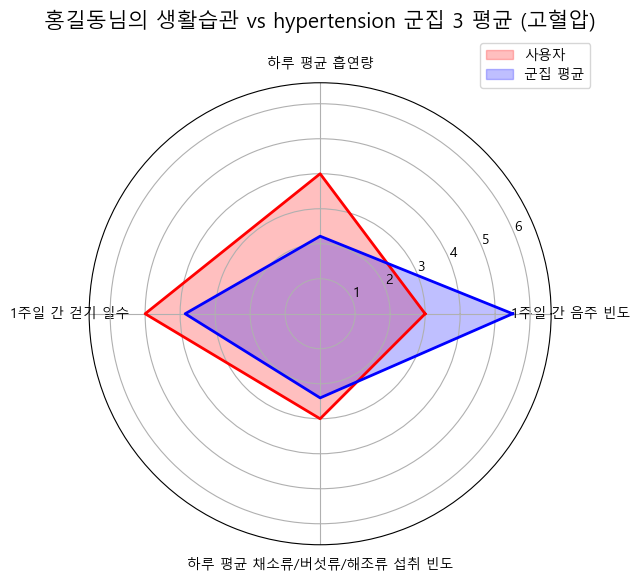


--- 생활 습관 비교 ---
| 항목                                     |   홍길동님 수치 |   군집 3 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            3.00 |               5.50 |
| 하루 평균 흡연량                         |            4.00 |               2.22 |
| 1주일 간 걷기 일수                       |            5.00 |               3.86 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            3.00 |               2.40 |

--- 개인화된 생활습관 분석 ---
군집 평균(5.50회)보다 음주 빈도(3.00회)가 적습니다. 좋은 습관입니다.
군집 평균(2.22개비)에 비해 흡연량(4.00개비)이 많으므로 주의가 필요합니다.
군집 평균(3.86일)보다 걷기 일수(5.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.40회/일)보다 채소류 섭취 빈도(3.00회/일)가 많습니다. 건강한 식습관입니다.
------------------------------

--- 홍길동님의 diabetes 상태: 정상 (그룹 1) ---
생활습관을 고려했을 때 정상 그룹의 5번 군집에 속합니다.

[정상 그룹의 5번 군집] 유형 더보기
음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


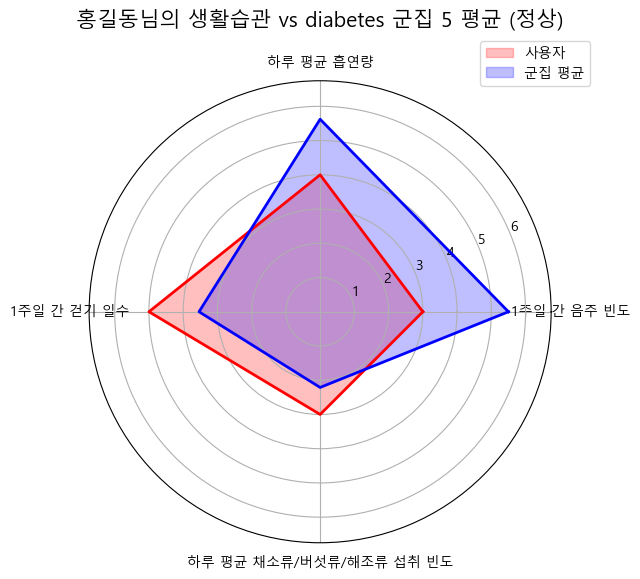

c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



--- 생활 습관 비교 ---
| 항목                                     |   홍길동님 수치 |   군집 5 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            3.00 |               5.50 |
| 하루 평균 흡연량                         |            4.00 |               5.62 |
| 1주일 간 걷기 일수                       |            5.00 |               3.54 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            3.00 |               2.21 |

--- 개인화된 생활습관 분석 ---
군집 평균(5.50회)보다 음주 빈도(3.00회)가 적습니다. 좋은 습관입니다.
군집 평균(5.62개비)보다 흡연량(4.00개비)이 적습니다. 좋은 습관입니다.
군집 평균(3.54일)보다 걷기 일수(5.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.21회/일)보다 채소류 섭취 빈도(3.00회/일)가 많습니다. 건강한 식습관입니다.
------------------------------

--- 홍길동님의 obesity 상태: 비만 (그룹 4) ---
생활습관을 고려했을 때 비만 그룹의 6번 군집에 속합니다.

[비만 그룹의 6번 군집] 유형 더보기
음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


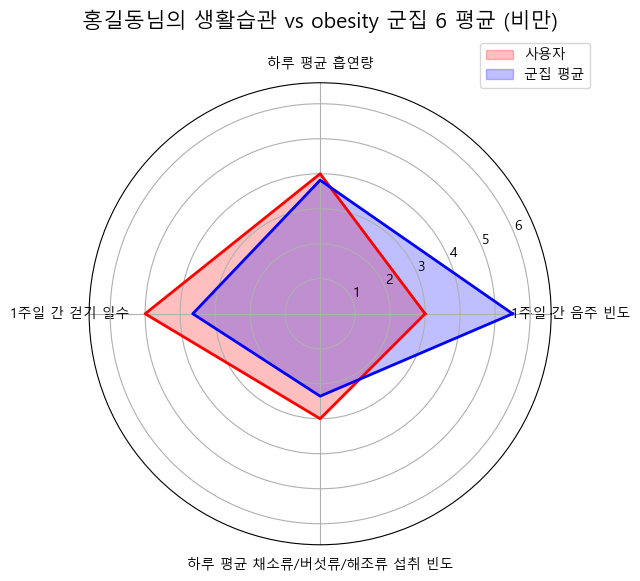


--- 생활 습관 비교 ---
| 항목                                     |   홍길동님 수치 |   군집 6 평균 수치 |
|:-----------------------------------------|----------------:|-------------------:|
| 1주일 간 음주 빈도                       |            3.00 |               5.50 |
| 하루 평균 흡연량                         |            4.00 |               3.82 |
| 1주일 간 걷기 일수                       |            5.00 |               3.64 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |            3.00 |               2.36 |

--- 개인화된 생활습관 분석 ---
군집 평균(5.50회)보다 음주 빈도(3.00회)가 적습니다. 좋은 습관입니다.
군집 평균(3.82개비)에 비해 흡연량(4.00개비)이 많으므로 주의가 필요합니다.
군집 평균(3.64일)보다 걷기 일수(5.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.36회/일)보다 채소류 섭취 빈도(3.00회/일)가 많습니다. 건강한 식습관입니다.
------------------------------


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import pickle
import os

# matplotlib 한글 설정 (필요시 이 파일에도 포함)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- Precalculated Cluster Means (Identical to your original code) ---
# ... (HE_HP_precalculated_means, HE_DM_precalculated_means, obe_precalculated_means) ...
# (Keep these as they are used for radar chart and table comparisons)

HE_HP_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.167185, 0.239176, 3.172158, 1.363797, 0.304851, 0.318776, 0.126048],
        '하루 평균 흡연량': [0.321646, 0.312566, 2.000000, 20.489297, 0.751894, 0.548831, 0.317757],
        '1주일 간 걷기 일수': [0.863567, 6.208025, 4.344316, 3.593272, 2.034091, 6.138927, 0.781931],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.000000, 3.000000, 2.163088, 2.080349, 0.895143, 1.871035, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.284722, 2.500000, 0.858974, 0.150502, 0.221657, 5.500000, 0.165176],
        '하루 평균 흡연량': [0.633333, 1.149606, 19.418803, 0.337793, 0.470769, 4.475000, 0.191214],
        '1주일 간 걷기 일수': [6.180556, 4.299213, 3.709402, 1.187291, 1.098462, 4.075000, 6.297158],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.796187, 2.448819, 2.183140, 3.000000, 1.785248, 2.387500, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.763355, 0.468248, 1.676724, 0.647671, 5.500000, 0.515860, 0.553569],
        '하루 평균 흡연량': [1.145833, 0.461916, 19.193966, 0.774869, 5.348837, 0.309278, 0.989384],
        '1주일 간 걷기 일수': [5.069444, 1.302211, 3.288793, 6.057592, 4.203488, 6.268041, 1.171975],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [0.925590, 3.000000, 2.207806, 2.000000, 2.347993, 3.000000, 1.914155]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [2.756947, 0.653964, 5.500000, 0.479380, 0.589461, 0.454250],
        '하루 평균 흡연량': [20.293194, 0.917178, 2.215827, 0.298479, 0.627753, 0.253644],
        '1주일 간 걷기 일수': [3.701571, 1.303681, 3.856115, 6.292776, 6.162996, 1.192420],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.301771, 1.801597, 2.403903, 3.000000, 1.854179, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

HE_DM_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.150946, 0.372085, 1.158756, 0.228997, 5.500000, 2.500000, 0.237966],
        '하루 평균 흡연량': [0.323770, 0.541776, 19.725768, 0.288396, 5.622449, 1.360502, 0.423890],
        '1주일 간 걷기 일수': [0.927049, 5.964267, 2.933806, 6.161263, 3.537415, 3.819749, 0.981501],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.771406, 2.114544, 3.000000, 2.211099, 2.249319, 1.774280]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.512626, 0.579406, 5.500000, 1.479076, 0.455288, 0.619097],
        '하루 평균 흡연량': [0.431724, 0.700143, 5.978166, 18.295597, 0.309375, 0.690799],
        '1주일 간 걷기 일수': [6.137931, 0.982783, 3.187773, 2.732704, 1.046875, 6.037707],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.842255, 2.362445, 2.143043, 3.000000, 1.812732]
    }, index=[0, 1, 2, 3, 4, 5]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.145881, 0.142308, 0.546853, 1.466873, 5.500000, 0.098474],
        '하루 평균 흡연량': [0.161702, 0.342857, 0.309091, 20.496350, 6.471264, 0.170241],
        '1주일 간 걷기 일수': [0.331915, 1.023810, 5.949495, 2.905109, 2.977011, 0.239946],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 0.886941, 2.630303, 2.296130, 2.390805, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

obe_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.041231, 0.499675, 0.140793, 4.500000, 0.955301, 0.043403],
        '하루 평균 흡연량': [0.000000, 0.253165, 0.078788, 7.933333, 17.162162, 0.046875],
        '1주일 간 걷기 일수': [0.144033, 5.886076, 0.454545, 2.766667, 3.513514, 0.138889],
        '하루 평균 채소 섭취 빈도': [3.000000, 2.239894, 0.892453, 2.080913, 2.135061, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [1.437870, 0.338664, 0.565225, 0.397819, 5.500000],
        '하루 평균 흡연량': [16.953177, 0.164277, 0.426172, 0.364297, 7.000000],
        '1주일 간 걷기 일수': [2.856187, 3.597969, 6.012378, 0.932149, 3.066327],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.208769, 3.000000, 1.795531, 1.804506, 2.276950]
    }, index=[0, 1, 2, 3, 4]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.378722, 0.526020, 0.595941, 5.500000, 1.447802, 0.462214],
        '하루 평균 흡연량': [0.326613, 0.415435, 0.581359, 4.986486, 19.017857, 0.407733],
        '1주일 간 걷기 일수': [0.987903, 0.957307, 5.990521, 3.567568, 2.852679, 6.130053],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.779103, 1.809968, 2.371122, 2.212353, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [0.519089, 0.550410, 2.104251, 0.601160, 0.417795, 5.500000, 1.564362],
        '하루 평균 흡연량': [0.609069, 0.366864, 34.342105, 0.599757, 0.407108, 3.816667, 16.915825],
        '1주일 간 걷기 일수': [1.055147, 6.143491, 3.000000, 5.928224, 1.080775, 3.638889, 2.787879],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.812550, 3.000000, 2.289474, 1.808696, 3.000000, 2.355556, 2.102071]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    5: pd.DataFrame({
        '1주일 간 음주 빈도': [0.172308, 0.832751, 0.241978, 5.500000, 2.500000, 0.380881, 0.341026],
        '하루 평균 흡연량': [0.200000, 21.196970, 0.914286, 4.147059, 1.562500, 0.330097, 1.216667],
        '1주일 간 걷기 일수': [5.973333, 3.090909, 5.062857, 3.323529, 4.734375, 0.961165, 0.550000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.890619, 1.764055, 2.189041, 2.069178, 3.000000, 1.813014]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    6: pd.DataFrame({
        '1주일 간 음주 빈도': [0.175570, 0.255583, 2.500000, 0.225175, 5.500000, 0.913462],
        '하루 평균 흡연량': [0.064815, 0.655914, 5.400000, 0.345455, 9.466667, 22.350000],
        '1주일 간 걷기 일수': [0.435185, 6.139785, 5.466667, 0.563636, 3.133333, 2.400000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 2.174311, 2.333333, 1.796090, 2.228493, 2.042740]
    }, index=[0, 1, 2, 3, 4, 5])
}


# --- Custom Cluster Descriptions ---
CUSTOM_CLUSTER_DESCRIPTIONS = {
    'hypertension': {
        1: { # HE_HP2 = 1 (정상 혈압)
            0: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 중간 정도입니다. 전반적으로 건강 습관이 좋지 않은 편으로, 특히 신체 활동이 매우 부족합니다. 이 군집은 건강 관리에 주의가 필요한 그룹으로 보입니다.",
            1: "음주와 흡연이 매우 낮고, 걷기는 매우 활발하며 채소 섭취도 높은 건강 지향적인 그룹입니다. 생활 습관 측면에서 가장 이상적인 군집 중 하나로 평가됩니다. 전반적으로 매우 건강한 생활 방식을 유지하고 있습니다.",
            2: "음주 횟수가 많고, 흡연량은 낮으며, 걷기는 중간 수준, 채소 섭취는 중간 정도입니다. 음주 습관을 개선할 필요가 있는 그룹입니다. 이 군집은 음주 빈도 조절을 통해 건강을 개선할 수 있습니다.",
            3: "음주와 걷기는 중간 수준이지만, 흡연량이 매우 높습니다. 채소 섭취는 중간 정도입니다. 흡연 습관 개선이 시급한 고위험군으로, 흡연으로 인한 건강 문제가 우려됩니다.",
            4: "음주와 흡연이 낮은 수준이고, 걷기는 낮은 편이며 채소 섭취도 낮습니다. 전반적으로 건강 습관이 부족한 그룹입니다. 이 군집은 신체 활동과 식습관 개선이 필요한 그룹입니다.",
            5: "음주와 흡연이 낮은 수준이고, 걷기는 매우 활발하며 채소 섭취는 중간 정도입니다. 흡연과 음주는 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다.",
            6: "음주, 흡연, 걷기 모두 매우 낮은 수준이지만 채소 섭취는 높은 편입니다. 전반적으로 활동량이 매우 부족한 그룹으로, 특히 신체 활동 증진이 필요합니다. 건강한 식습관을 유지하고 있지만, 운동 부족이 문제입니다.",
        },
        2: { # HE_HP2 = 2 (주의 혈압)
            0: "음주와 흡연은 낮은 수준이지만, 걷기 활동은 매우 활발하며 채소 섭취는 낮은 편입니다. 운동은 잘 하고 있지만, 식습관 개선이 필요한 그룹입니다. 전반적인 건강 습관은 양호하나 채소 섭취 증진이 중요합니다.",
            1: "음주와 흡연은 중간 수준이고, 걷기 및 채소 섭취도 중간 정도입니다. 전반적으로 중간 수준의 건강 습관을 가진 그룹입니다. 특정 문제가 두드러지지 않지만, 전반적인 개선 노력이 필요합니다.",
            2: "음주는 낮지만 흡연량이 매우 높고, 걷기와 채소 섭취는 중간 수준입니다. 흡연 습관 개선이 시급한 고위험군으로, 혈압 관리에 있어 특히 주의가 필요합니다. 흡연으로 인한 건강 악화 가능성이 높습니다.",
            3: "음주와 흡연은 낮은 수준이고, 걷기는 낮은 편이며 채소 섭취는 높은 편입니다. 활동량이 부족하지만, 식습관은 비교적 건강한 그룹입니다. 신체 활동량 증진에 집중해야 합니다.",
            4: "음주와 흡연이 낮은 수준이고, 걷기는 낮은 편이며 채소 섭취도 낮은 편입니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
            5: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기 및 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            6: "음주와 흡연은 낮은 수준이지만, 걷기 활동이 매우 활발하며 채소 섭취도 높은 편입니다. 매우 건강한 생활 습관을 가진 그룹입니다. 전반적으로 건강 관리를 잘 하고 있는 모범적인 그룹입니다.",
        },
        3: { # HE_HP2 = 3 (고혈압 전단계)
            0: "음주와 흡연은 낮고, 걷기는 높지만 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
            1: "음주와 흡연은 낮은 수준이고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            2: "음주는 중간 수준, 흡연량은 매우 높고, 걷기와 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군이며, 음주 습관 관리도 필요합니다. 전반적인 생활 습관 개선이 절실합니다.",
            3: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 중간 정도입니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기 및 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 생활 습관 전반의 개선이 필요합니다.",
            5: "음주와 흡연은 낮은 수준이지만, 걷기 활동은 매우 활발하며 채소 섭취는 높은 편입니다. 매우 건강한 생활 습관을 가진 그룹입니다. 가장 건강한 생활 방식을 유지하고 있습니다.",
            6: "음주와 흡연은 낮고, 걷기는 낮은 편이며 채소 섭취도 낮습니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
        },
        4: { # HE_HP2 = 4 (고혈압)
            0: "음주와 걷기는 중간 수준이지만, 흡연량이 매우 높고 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 초고위험군입니다. 혈압 관리에 있어 가장 집중적인 개입이 필요한 그룹입니다.",
            1: "음주, 흡연, 걷기, 채소 섭취 모두 낮은 수준입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            3: "음주와 흡연은 낮은 수준이고, 걷기 활동이 매우 활발하며 채소 섭취는 높은 편입니다. 매우 건강한 생활 습관을 가진 그룹입니다. 고혈압 상태임에도 건강 관리를 잘 하고 있습니다.",
            4: "음주와 흡연은 낮고, 걷기는 높지만 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
            5: "음주와 흡연은 낮은 수준이고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
        }
    },
    'diabetes': {
        1: { # HE_DM_HbA1c2 = 1 (정상)
            0: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 높습니다. 전반적으로 활동량이 부족하지만, 식습관은 건강한 그룹입니다. 운동량 증진이 필요합니다.",
            1: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 신체 활동은 비교적 꾸준하지만, 식습관 개선이 필요합니다. 전반적인 건강 관리에 주의가 필요합니다.",
            2: "음주는 중간, 흡연량은 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            3: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 높습니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 가장 이상적인 건강 습관을 가진 군집입니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            5: "음주와 걷기는 중간 수준이고, 흡연은 낮으며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            6: "음주, 흡연, 걷기, 채소 섭취 모두 낮은 수준입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
        },
        2: { # HE_DM_HbA1c2 = 2 (당뇨병 전단계)
            0: "음주와 흡연은 낮은 수준이지만, 걷기 활동은 매우 활발하며 채소 섭취는 높습니다. 운동은 잘 하고 있지만, 전반적인 건강 습관은 양호합니다. 건강 관리를 잘 하고 있는 그룹입니다.",
            1: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
            2: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            3: "음주는 중간, 흡연량은 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            4: "음주와 흡연은 낮은 수준이고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            5: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
        },
        3: { # HE_DM_HbA1c2 = 3 (당뇨병)
            0: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 높습니다. 전반적으로 활동량이 부족하지만, 식습관은 건강한 그룹입니다. 운동량 증진이 필요합니다.",
            1: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주와 흡연은 낮지만, 걷기는 중간이며 채소 섭취는 중간 정도입니다. 흡연과 음주는 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 당뇨병 관리에 있어 좋은 습관을 가지고 있습니다.",
            3: "음주는 중간, 흡연량은 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            5: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 중간 정도입니다. 전반적으로 활동량이 매우 부족한 그룹으로, 특히 신체 활동 증진이 필요합니다. 건강한 식습관을 유지하고 있지만, 운동 부족이 문제입니다.",
        }
    },
    'obesity': {
        1: { # HE_obe2 = 1 (저체중)
            0: "음주, 흡연, 걷기 모두 매우 낮은 수준이지만 채소 섭취는 높습니다. 활동량 부족이 심각하지만, 채소 위주의 식습관을 유지하고 있습니다. 건강 증진을 위해 신체 활동을 늘려야 합니다.",
            1: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 중간 정도입니다. 전반적으로 건강 습관이 비교적 양호한 그룹입니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            2: "음주, 흡연, 걷기 모두 낮은 수준이고 채소 섭취도 낮습니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 절실합니다.",
            3: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주 습관과 흡연 습관 개선이 필요한 고위험군입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            4: "음주는 낮지만 흡연량이 매우 높고, 걷기와 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            5: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 중간 정도입니다. 전반적으로 활동량이 매우 부족한 그룹으로, 특히 신체 활동 증진이 필요합니다. 건강한 식습관을 유지하고 있지만, 운동 부족이 문제입니다.",
        },
        2: { # HE_obe2 = 2 (정상 체중)
            0: "음주는 낮고, 걷기는 중간이며 채소 섭취는 높습니다. 흡연량은 매우 낮습니다. 신체 활동과 식습관 모두 양호하여 건강 관리를 잘 하고 있는 그룹입니다.",
            1: "음주, 흡연, 걷기, 채소 섭취 모두 낮은 수준입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
            3: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
        },
        3: { # HE_obe2 = 3 (과체중)
            0: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            1: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주와 흡연은 낮지만, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 걷기 운동은 어느 정도 하지만, 전반적인 식습관 개선이 필요합니다. 건강한 생활 습관을 위해 노력해야 합니다.",
            3: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            4: "음주는 중간, 흡연량이 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            5: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 높습니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 가장 이상적인 건강 습관을 가진 군집입니다.",
        },
        4: { # HE_obe2 = 4 (비만)
            0: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            1: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 높습니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 비만 상태임에도 건강한 생활 습관을 유지하고 있습니다.",
            2: "음주는 중간이지만 흡연량이 매우 높고, 걷기와 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 초고위험군으로, 비만과 흡연 모두 관리해야 합니다. 건강 문제가 심각할 수 있습니다.",
            3: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 걷기 운동은 어느 정도 하지만, 전반적인 식습관 개선이 필요합니다. 건강한 생활 습관을 위해 노력해야 합니다.",
            4: "음주와 흡연은 낮고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            5: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            6: "음주는 중간이지만 흡연량이 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
        },
        5: { # HE_obe2 = 5 (고도 비만)
            0: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 높습니다. 전반적으로 신체 활동과 식습관 모두 양호하여 건강 관리를 잘 하고 있는 그룹입니다. 고도 비만임에도 건강한 생활 습관을 유지하고 있습니다.",
            1: "음주는 낮지만 흡연량이 매우 높고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 흡연 습관 개선이 시급한 초고위험군으로, 고도 비만과 흡연 모두 관리해야 합니다. 건강 문제가 심각할 수 있습니다.",
            2: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 신체 활동은 비교적 꾸준하지만, 식습관 개선이 필요합니다. 전반적인 건강 관리에 주의가 필요합니다.",
            3: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            4: "음주와 걷기는 중간 수준이고, 흡연은 중간이며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            5: "음주와 흡연은 낮고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            6: "음주와 걷기는 낮은 수준이고, 흡연량은 중간이며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 절실합니다.",
        },
        6: { # HE_obe2 = 6 (초고도 비만)
            0: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            1: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 중간입니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다.",
            2: "음주와 걷기는 중간 수준이고, 흡연은 중간이며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            3: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            5: "음주는 낮지만 흡연량이 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
        }
    }
}


# (Removed FEATURE_THRESHOLDS and classify_feature_level)


# --- Functions for user input, disease determination, cluster determination, and plotting ---
# (These functions remain the same as before)
# ... get_user_input, determine_disease_groups, determine_cluster_with_precalculated_means, plot_radar_chart ...

def get_user_input():
    print("사용자의 건강 및 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    sbp = float(input("수축기 혈압 (mmHg): "))

    dbp = float(input("이완기 혈압 (mmHg): "))

    fglu = float(input("공복혈당 (mg/dL): "))

    bmi = float(input("BMI (kg/m²): "))
    
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (회): "))
    daily_veg = float(input("하루 평균 채소류/버섯류/해조류 섭취 빈도 (회/일): "))
    return name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg

def determine_disease_groups(sbp, dbp, fglu, bmi):
    # 고혈압
    if sbp >= 140 or dbp >= 90:
        he_hp2 = 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        he_hp2 = 3
    elif 120 <= sbp <= 129 and dbp < 80:
        he_hp2 = 2
    else:
        he_hp2 = 1
    
    # 당뇨
    if fglu >= 126:
        he_dm = 3
    elif 100 <= fglu < 126:
        he_dm = 2
    else:
        he_dm = 1
    
    # 비만
    if bmi <= 18.5:
        he_bmi = 1
    elif 18.5 < bmi <= 22.9:
        he_bmi = 2
    elif 22.9 < bmi <= 24.9:
        he_bmi = 3
    elif 24.9 < bmi <= 29.9:
        he_bmi = 4
    elif 29.9 < bmi <= 34.9:
        he_bmi = 5
    else:
        he_bmi = 6
    
    return he_hp2, he_dm, he_bmi

def determine_cluster_with_precalculated_means(user_data_weekly_daily, group, disease, scaler, precalculated_means_dict, selected_cols):
    group_int = int(group)
    if group_int not in precalculated_means_dict:
        print(f"{disease} 그룹 {group_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return None, None
    
    cluster_means_precalculated_text_names = precalculated_means_dict[group_int].copy()
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': 'LS_VEG1'
    }
    
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)
        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            print(f"경고: {disease}의 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 데이터에 없습니다.")
            return None, None
    
    if cluster_means_precalculated_internal_names.isnull().values.any():
        print(f"경고: {disease}의 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")
        return None, None
    
    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols])
    
    # Scaling for user data should match the scaling used during training
    # BD1_11 (weekly_alcohol) was transformed to annual in training
    # LS_VEG1 (daily_veg) was transformed to annual in training
    user_data_transformed = [
        user_data_weekly_daily[0] * 52,  # Convert weekly alcohol to annual for BD1_11
        user_data_weekly_daily[1],       # Daily smoking remains daily for tobacco
        user_data_weekly_daily[2],       # Weekly exercise remains weekly for BE3_31
        user_data_weekly_daily[3] * 365  # Convert daily veg to annual for LS_VEG1
    ]
    
    user_data_scaled = scaler.transform([user_data_transformed])
    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled, axis=1)
    closest_cluster = np.argmin(distances)
    cluster_means = precalculated_means_dict[group_int].iloc[closest_cluster]
    
    return closest_cluster, cluster_means

def plot_radar_chart(user_data, cluster_mean, categories, title):
    # Ensure all inputs are lists and convert Series to list if necessary
    user_data_list = user_data if isinstance(user_data, list) else user_data.tolist()
    cluster_mean_list = cluster_mean if isinstance(cluster_mean, list) else cluster_mean.tolist()

    values_user = user_data_list[:]
    values_cluster = cluster_mean_list[:]
    
    all_values = values_user + values_cluster
    # Avoid division by zero or issues with empty lists
    max_val = max(all_values) if all_values else 1
    
    values_user = values_user + values_user[:1]
    values_cluster = values_cluster + values_cluster[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max_val * 1.2)
    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()


def run_health_comparison(scaler_filepath="scalers.pkl"):
    """
    저장된 스케일러를 로드하고 사용자 입력을 받아 건강 비교를 수행합니다.
    """
    selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'LS_VEG1']
    item_names = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '하루 평균 채소류/버섯류/해조류 섭취 빈도']
    
    scalers = {}
    
    # 스케일러 로드 시도
    if os.path.exists(scaler_filepath):
        print(f"✅ 스케일러 파일 '{scaler_filepath}'을(를) 로드합니다.")
        try:
            with open(scaler_filepath, 'rb') as f:
                scalers = pickle.load(f)
        except Exception as e:
            print(f"❌ 스케일러 로드 중 오류 발생: {e}. 'train_and_save_scalers.py'를 다시 실행해야 할 수 있습니다.")
            return # 오류 발생 시 종료
    else:
        print(f"❌ 스케일러 파일 '{scaler_filepath}'이(가) 존재하지 않습니다. 먼저 'train_and_save_scalers.py'를 실행하여 스케일러를 생성해주세요.")
        return # 파일 없으면 종료

    # 사용자 입력 받기
    name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg = get_user_input()

    if name is None: # User chose to exit due to suspicious input
        print("입력 오류로 인해 프로그램을 종료합니다.")
        return
        
    he_hp2, he_dm, he_bmi = determine_disease_groups(sbp, dbp, fglu, bmi)
    
    disease_labels = {
        'hypertension': {1: "정상 혈압", 2: "주의 혈압", 3: "고혈압 전단계", 4: "고혈압"},
        'diabetes': {1: "정상", 2: "당뇨 전단계", 3: "당뇨"},
        'obesity': {1: "저체중", 2: "정상 체중", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
    }
    
    diseases = [
        ('hypertension', he_hp2, HE_HP_precalculated_means, 'HE_HP2'),
        ('diabetes', he_dm, HE_DM_precalculated_means, 'HE_DM'),
        ('obesity', he_bmi, obe_precalculated_means, 'HE_BMI_class')
    ]
    
    user_data = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
    
    for disease, group, precalculated_means, col in diseases:
        group_int = int(group)
        print(f"\n--- {name}님의 {disease} 상태: {disease_labels[disease][group_int]} (그룹 {group_int}) ---")
        
        # 해당 그룹의 스케일러 로드
        scaler_key = (disease, group_int)
        if scaler_key not in scalers:
            print(f"오류: {disease} 그룹 {group_int}에 대한 스케일러가 로드되지 않았습니다. 'train_and_save_scalers.py'를 다시 실행해야 합니다.")
            continue # 다음 질병으로 넘어감
        
        current_scaler = scalers[scaler_key]
        
        cluster, cluster_means = determine_cluster_with_precalculated_means(
            user_data, group_int, disease, current_scaler, precalculated_means, selected_cols
        )
        
        if cluster is not None:
            # Display cluster number as 1-indexed for user-friendliness
            display_cluster = cluster + 1 # Convert 0-indexed cluster to 1-indexed for display
            print(f"생활습관을 고려했을 때 {disease_labels[disease][group_int]} 그룹의 {display_cluster}번 군집에 속합니다.")
            
            # --- 군집 특징 추출 및 출력 (Using custom descriptions) ---
            print(f"\n[{disease_labels[disease][group_int]} 그룹의 {display_cluster}번 군집] 유형 더보기")
            
            # Look up the custom description using the disease name and display_cluster (1-indexed)
            try:
                # Use the disease key ('hypertension', 'diabetes', 'obesity') and then the group_int, then display_cluster
                cluster_desc = CUSTOM_CLUSTER_DESCRIPTIONS[disease][group_int][cluster] # Use original 0-indexed cluster for dictionary lookup
                print(cluster_desc)
            except KeyError:
                print(f"이 군집({disease_labels[disease][group_int]} 그룹의 {display_cluster}번 군집)에 대한 사용자 정의 설명이 없습니다. CUSTOM_CLUSTER_DESCRIPTIONS에 추가해주세요.")
            

            # 1. "군집의 평균 수치와 내 건강 상태를 비교합니다" 문구 출력
            print("\n군집의 평균 수치와 내 건강 상태를 비교합니다.")
            
            # 2. 레이더 차트 출력
            plot_radar_chart(
                user_data,
                cluster_means.tolist(),
                item_names,
                f"{name}님의 생활습관 vs {disease} 군집 {display_cluster} 평균 ({disease_labels[disease][group_int]})"
            )

            # 3. 사용자의 수치와 군집의 수치가 적힌 표 출력
            table_data = {
                '항목': item_names,
                f'{name}님 수치': user_data,
                f'군집 {display_cluster} 평균 수치': cluster_means.tolist()
            }
            comparison_df = pd.DataFrame(table_data)
            print("\n--- 생활 습관 비교 ---")
            print(comparison_df.to_markdown(index=False, floatfmt=".2f"))
            
            # 4. 사용자 수치와 군집 수치를 비교하는 문구 출력 (개인화된 분석)
            print("\n--- 개인화된 생활습관 분석 ---")
            comparison_comments = []

            # 음주 빈도 비교
            # User data: [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
            # Cluster means: ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '하루 평균 채소류/버섯류/해조류 섭취 빈도']
            
            if user_data[0] > cluster_means['1주일 간 음주 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 음주 빈도']:.2f}회)에 비해 음주 빈도({user_data[0]:.2f}회)가 많으므로 주의가 필요합니다.")
            elif user_data[0] < cluster_means['1주일 간 음주 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 음주 빈도']:.2f}회)보다 음주 빈도({user_data[0]:.2f}회)가 적습니다. 좋은 습관입니다.")
            else:
                comparison_comments.append(f"음주 빈도({user_data[0]:.2f}회)가 군집 평균과 유사합니다.")

            # 흡연량 비교
            if user_data[1] > cluster_means['하루 평균 흡연량']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 흡연량']:.2f}개비)에 비해 흡연량({user_data[1]:.2f}개비)이 많으므로 주의가 필요합니다.")
            elif user_data[1] < cluster_means['하루 평균 흡연량']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 흡연량']:.2f}개비)보다 흡연량({user_data[1]:.2f}개비)이 적습니다. 좋은 습관입니다.")
            else:
                comparison_comments.append(f"흡연량({user_data[1]:.2f}개비)이 군집 평균과 유사합니다.")

            # 걷기 일수 비교
            if user_data[2] < cluster_means['1주일 간 걷기 일수']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 걷기 일수']:.2f}일)에 비해 걷기 일수({user_data[2]:.2f}일)가 적으므로 활동량을 늘리는 것이 좋습니다.")
            elif user_data[2] > cluster_means['1주일 간 걷기 일수']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 걷기 일수']:.2f}일)보다 걷기 일수({user_data[2]:.2f}일)가 많습니다. 활동량이 충분합니다.")
            else:
                comparison_comments.append(f"걷기 일수({user_data[2]:.2f}일)가 군집 평균과 유사합니다.")
            
            # 채소 섭취 빈도 비교
            if user_data[3] < cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:.2f}회/일)에 비해 채소류 섭취 빈도({user_data[3]:.2f}회/일)가 적으므로 섭취량을 늘리는 것을 권장합니다.")
            elif user_data[3] > cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:.2f}회/일)보다 채소류 섭취 빈도({user_data[3]:.2f}회/일)가 많습니다. 건강한 식습관입니다.")
            else:
                comparison_comments.append(f"채소류 섭취 빈도({user_data[3]:.2f}회/일)가 군집 평균과 유사합니다.")

            for comment in comparison_comments:
                print(comment)
            print("-" * 30)


if __name__ == "__main__":
    run_health_comparison()

제발 마지막 

✅ 스케일러 파일 'scalers.pkl'을(를) 로드합니다.
사용자의 건강 및 생활습관 수치를 입력해주세요.

--- kk님의 hypertension 상태: 고혈압 (그룹 4) ---
생활습관을 고려했을 때 고혈압 그룹의 3번 군집에 속합니다.

[고혈압 그룹의 3번 군집] 유형 더보기
음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군입니다. 건강에 해로운 습관들을 개선해야 합니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


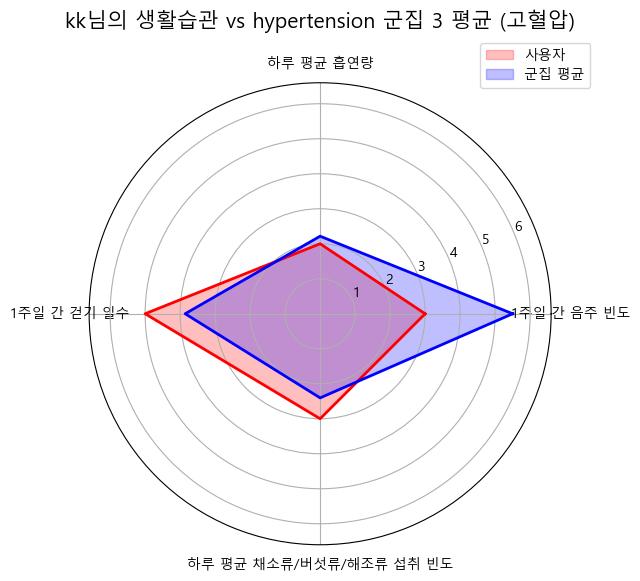


--- 생활 습관 비교 ---
| 항목                                     |   kk님 수치 |   군집 3 평균 수치 |
|:-----------------------------------------|------------:|-------------------:|
| 1주일 간 음주 빈도                       |        3.00 |               5.50 |
| 하루 평균 흡연량                         |        2.00 |               2.22 |
| 1주일 간 걷기 일수                       |        5.00 |               3.86 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |        3.00 |               2.40 |

--- 개인화된 생활습관 분석 ---
군집 평균(5.50회)보다 음주 빈도(3.00회)가 적습니다. 좋은 습관입니다.
군집 평균(2.22개비)보다 흡연량(2.00개비)이 적습니다. 좋은 습관입니다.
군집 평균(3.86일)보다 걷기 일수(5.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.40회/일)보다 채소류 섭취 빈도(3.00회/일)가 많습니다. 건강한 식습관입니다.
------------------------------

--- kk님의 diabetes 상태: 정상 (그룹 1) ---
생활습관을 고려했을 때 정상 그룹의 6번 군집에 속합니다.

[정상 그룹의 6번 군집] 유형 더보기
음주와 걷기는 중간 수준이고, 흡연은 낮으며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


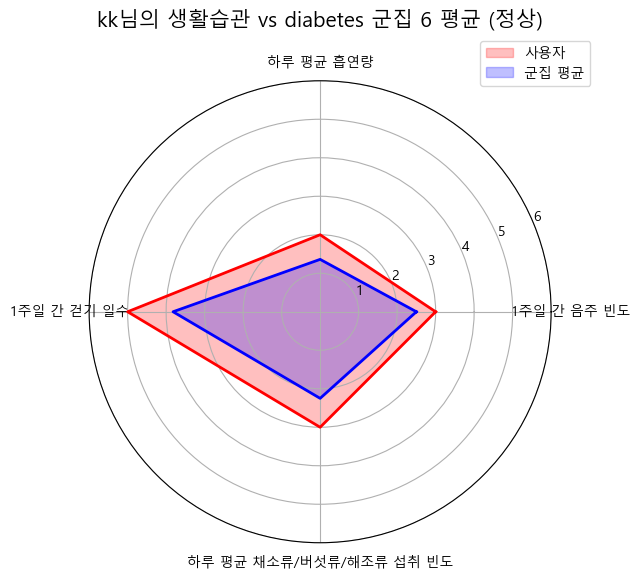

c:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



--- 생활 습관 비교 ---
| 항목                                     |   kk님 수치 |   군집 6 평균 수치 |
|:-----------------------------------------|------------:|-------------------:|
| 1주일 간 음주 빈도                       |        3.00 |               2.50 |
| 하루 평균 흡연량                         |        2.00 |               1.36 |
| 1주일 간 걷기 일수                       |        5.00 |               3.82 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |        3.00 |               2.25 |

--- 개인화된 생활습관 분석 ---
군집 평균(2.50회)에 비해 음주 빈도(3.00회)가 많으므로 주의가 필요합니다.
군집 평균(1.36개비)에 비해 흡연량(2.00개비)이 많으므로 주의가 필요합니다.
군집 평균(3.82일)보다 걷기 일수(5.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.25회/일)보다 채소류 섭취 빈도(3.00회/일)가 많습니다. 건강한 식습관입니다.
------------------------------

--- kk님의 obesity 상태: 비만 (그룹 4) ---
생활습관을 고려했을 때 비만 그룹의 6번 군집에 속합니다.

[비만 그룹의 6번 군집] 유형 더보기
음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.

군집의 평균 수치와 내 건강 상태를 비교합니다.


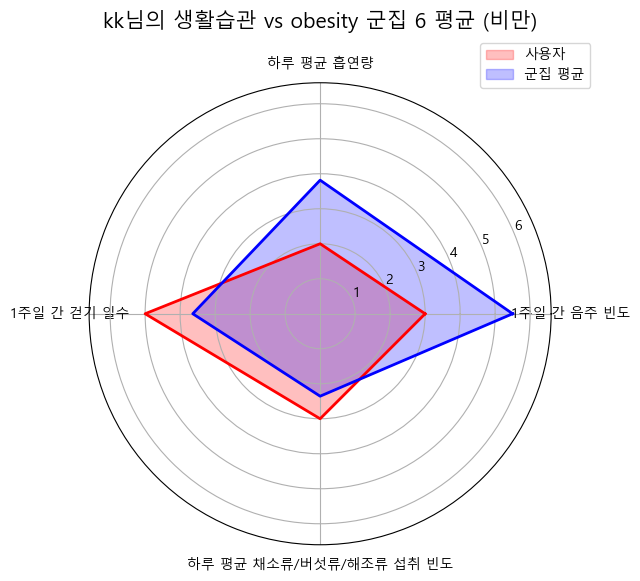


--- 생활 습관 비교 ---
| 항목                                     |   kk님 수치 |   군집 6 평균 수치 |
|:-----------------------------------------|------------:|-------------------:|
| 1주일 간 음주 빈도                       |        3.00 |               5.50 |
| 하루 평균 흡연량                         |        2.00 |               3.82 |
| 1주일 간 걷기 일수                       |        5.00 |               3.64 |
| 하루 평균 채소류/버섯류/해조류 섭취 빈도 |        3.00 |               2.36 |

--- 개인화된 생활습관 분석 ---
군집 평균(5.50회)보다 음주 빈도(3.00회)가 적습니다. 좋은 습관입니다.
군집 평균(3.82개비)보다 흡연량(2.00개비)이 적습니다. 좋은 습관입니다.
군집 평균(3.64일)보다 걷기 일수(5.00일)가 많습니다. 활동량이 충분합니다.
군집 평균(2.36회/일)보다 채소류 섭취 빈도(3.00회/일)가 많습니다. 건강한 식습관입니다.
------------------------------


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import pickle
import os

# matplotlib 한글 설정 (필요시 이 파일에도 포함)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# --- Precalculated Cluster Means (Identical to your original code) ---
# ... (HE_HP_precalculated_means, HE_DM_precalculated_means, obe_precalculated_means) ...
# (Keep these as they are used for radar chart and table comparisons)

HE_HP_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.167185, 0.239176, 3.172158, 1.363797, 0.304851, 0.318776, 0.126048],
        '하루 평균 흡연량': [0.321646, 0.312566, 2.000000, 20.489297, 0.751894, 0.548831, 0.317757],
        '1주일 간 걷기 일수': [0.863567, 6.208025, 4.344316, 3.593272, 2.034091, 6.138927, 0.781931],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.000000, 3.000000, 2.163088, 2.080349, 0.895143, 1.871035, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.284722, 2.500000, 0.858974, 0.150502, 0.221657, 5.500000, 0.165176],
        '하루 평균 흡연량': [0.633333, 1.149606, 19.418803, 0.337793, 0.470769, 4.475000, 0.191214],
        '1주일 간 걷기 일수': [6.180556, 4.299213, 3.709402, 1.187291, 1.098462, 4.075000, 6.297158],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.796187, 2.448819, 2.183140, 3.000000, 1.785248, 2.387500, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.763355, 0.468248, 1.676724, 0.647671, 5.500000, 0.515860, 0.553569],
        '하루 평균 흡연량': [1.145833, 0.461916, 19.193966, 0.774869, 5.348837, 0.309278, 0.989384],
        '1주일 간 걷기 일수': [5.069444, 1.302211, 3.288793, 6.057592, 4.203488, 6.268041, 1.171975],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [0.925590, 3.000000, 2.207806, 2.000000, 2.347993, 3.000000, 1.914155]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [2.756947, 0.653964, 5.500000, 0.479380, 0.589461, 0.454250],
        '하루 평균 흡연량': [20.293194, 0.917178, 2.215827, 0.298479, 0.627753, 0.253644],
        '1주일 간 걷기 일수': [3.701571, 1.303681, 3.856115, 6.292776, 6.162996, 1.192420],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.301771, 1.801597, 2.403903, 3.000000, 1.854179, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

HE_DM_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.150946, 0.372085, 1.158756, 0.228997, 5.500000, 2.500000, 0.237966],
        '하루 평균 흡연량': [0.323770, 0.541776, 19.725768, 0.288396, 5.622449, 1.360502, 0.423890],
        '1주일 간 걷기 일수': [0.927049, 5.964267, 2.933806, 6.161263, 3.537415, 3.819749, 0.981501],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.771406, 2.114544, 3.000000, 2.211099, 2.249319, 1.774280]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [0.512626, 0.579406, 5.500000, 1.479076, 0.455288, 0.619097],
        '하루 평균 흡연량': [0.431724, 0.700143, 5.978166, 18.295597, 0.309375, 0.690799],
        '1주일 간 걷기 일수': [6.137931, 0.982783, 3.187773, 2.732704, 1.046875, 6.037707],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.842255, 2.362445, 2.143043, 3.000000, 1.812732]
    }, index=[0, 1, 2, 3, 4, 5]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.145881, 0.142308, 0.546853, 1.466873, 5.500000, 0.098474],
        '하루 평균 흡연량': [0.161702, 0.342857, 0.309091, 20.496350, 6.471264, 0.170241],
        '1주일 간 걷기 일수': [0.331915, 1.023810, 5.949495, 2.905109, 2.977011, 0.239946],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 0.886941, 2.630303, 2.296130, 2.390805, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5])
}

obe_precalculated_means = {
    1: pd.DataFrame({
        '1주일 간 음주 빈도': [0.041231, 0.499675, 0.140793, 4.500000, 0.955301, 0.043403],
        '하루 평균 흡연량': [0.000000, 0.253165, 0.078788, 7.933333, 17.162162, 0.046875],
        '1주일 간 걷기 일수': [0.144033, 5.886076, 0.454545, 2.766667, 3.513514, 0.138889],
        '하루 평균 채소 섭취 빈도': [3.000000, 2.239894, 0.892453, 2.080913, 2.135061, 2.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    2: pd.DataFrame({
        '1주일 간 음주 빈도': [1.437870, 0.338664, 0.565225, 0.397819, 5.500000],
        '하루 평균 흡연량': [16.953177, 0.164277, 0.426172, 0.364297, 7.000000],
        '1주일 간 걷기 일수': [2.856187, 3.597969, 6.012378, 0.932149, 3.066327],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [2.208769, 3.000000, 1.795531, 1.804506, 2.276950]
    }, index=[0, 1, 2, 3, 4]),
    3: pd.DataFrame({
        '1주일 간 음주 빈도': [0.378722, 0.526020, 0.595941, 5.500000, 1.447802, 0.462214],
        '하루 평균 흡연량': [0.326613, 0.415435, 0.581359, 4.986486, 19.017857, 0.407733],
        '1주일 간 걷기 일수': [0.987903, 0.957307, 5.990521, 3.567568, 2.852679, 6.130053],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.779103, 1.809968, 2.371122, 2.212353, 3.000000]
    }, index=[0, 1, 2, 3, 4, 5]),
    4: pd.DataFrame({
        '1주일 간 음주 빈도': [0.519089, 0.550410, 2.104251, 0.601160, 0.417795, 5.500000, 1.564362],
        '하루 평균 흡연량': [0.609069, 0.366864, 34.342105, 0.599757, 0.407108, 3.816667, 16.915825],
        '1주일 간 걷기 일수': [1.055147, 6.143491, 3.000000, 5.928224, 1.080775, 3.638889, 2.787879],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [1.812550, 3.000000, 2.289474, 1.808696, 3.000000, 2.355556, 2.102071]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    5: pd.DataFrame({
        '1주일 간 음주 빈도': [0.172308, 0.832751, 0.241978, 5.500000, 2.500000, 0.380881, 0.341026],
        '하루 평균 흡연량': [0.200000, 21.196970, 0.914286, 4.147059, 1.562500, 0.330097, 1.216667],
        '1주일 간 걷기 일수': [5.973333, 3.090909, 5.062857, 3.323529, 4.734375, 0.961165, 0.550000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 1.890619, 1.764055, 2.189041, 2.069178, 3.000000, 1.813014]
    }, index=[0, 1, 2, 3, 4, 5, 6]),
    6: pd.DataFrame({
        '1주일 간 음주 빈도': [0.175570, 0.255583, 2.500000, 0.225175, 5.500000, 0.913462],
        '하루 평균 흡연량': [0.064815, 0.655914, 5.400000, 0.345455, 9.466667, 22.350000],
        '1주일 간 걷기 일수': [0.435185, 6.139785, 5.466667, 0.563636, 3.133333, 2.400000],
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': [3.000000, 2.174311, 2.333333, 1.796090, 2.228493, 2.042740]
    }, index=[0, 1, 2, 3, 4, 5])
}


# --- Custom Cluster Descriptions ---
CUSTOM_CLUSTER_DESCRIPTIONS = {
    'hypertension': {
        1: { # HE_HP2 = 1 (정상 혈압)
            0: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 중간 정도입니다. 전반적으로 건강 습관이 좋지 않은 편으로, 특히 신체 활동이 매우 부족합니다. 이 군집은 건강 관리에 주의가 필요한 그룹으로 보입니다.",
            1: "음주와 흡연이 매우 낮고, 걷기는 매우 활발하며 채소 섭취도 높은 건강 지향적인 그룹입니다. 생활 습관 측면에서 가장 이상적인 군집 중 하나로 평가됩니다. 전반적으로 매우 건강한 생활 방식을 유지하고 있습니다.",
            2: "음주 횟수가 많고, 흡연량은 낮으며, 걷기는 중간 수준, 채소 섭취는 중간 정도입니다. 음주 습관을 개선할 필요가 있는 그룹입니다. 이 군집은 음주 빈도 조절을 통해 건강을 개선할 수 있습니다.",
            3: "음주와 걷기는 중간 수준이지만, 흡연량이 매우 높습니다. 채소 섭취는 중간 정도입니다. 흡연 습관 개선이 시급한 고위험군으로, 흡연으로 인한 건강 문제가 우려됩니다.",
            4: "음주와 흡연이 낮은 수준이고, 걷기는 낮은 편이며 채소 섭취도 낮습니다. 전반적으로 건강 습관이 부족한 그룹입니다. 이 군집은 신체 활동과 식습관 개선이 필요한 그룹입니다.",
            5: "음주와 흡연이 낮은 수준이고, 걷기는 매우 활발하며 채소 섭취는 중간 정도입니다. 흡연과 음주는 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다.",
            6: "음주, 흡연, 걷기 모두 매우 낮은 수준이지만 채소 섭취는 높은 편입니다. 전반적으로 활동량이 매우 부족한 그룹으로, 특히 신체 활동 증진이 필요합니다. 건강한 식습관을 유지하고 있지만, 운동 부족이 문제입니다.",
        },
        2: { # HE_HP2 = 2 (주의 혈압)
            0: "음주와 흡연은 낮은 수준이지만, 걷기 활동은 매우 활발하며 채소 섭취는 낮은 편입니다. 운동은 잘 하고 있지만, 식습관 개선이 필요한 그룹입니다. 전반적인 건강 습관은 양호하나 채소 섭취 증진이 중요합니다.",
            1: "음주와 흡연은 중간 수준이고, 걷기 및 채소 섭취도 중간 정도입니다. 전반적으로 중간 수준의 건강 습관을 가진 그룹입니다. 특정 문제가 두드러지지 않지만, 전반적인 개선 노력이 필요합니다.",
            2: "음주는 낮지만 흡연량이 매우 높고, 걷기와 채소 섭취는 중간 수준입니다. 흡연 습관 개선이 시급한 고위험군으로, 혈압 관리에 있어 특히 주의가 필요합니다. 흡연으로 인한 건강 악화 가능성이 높습니다.",
            3: "음주와 흡연은 낮은 수준이고, 걷기는 낮은 편이며 채소 섭취는 높은 편입니다. 활동량이 부족하지만, 식습관은 비교적 건강한 그룹입니다. 신체 활동량 증진에 집중해야 합니다.",
            4: "음주와 흡연이 낮은 수준이고, 걷기는 낮은 편이며 채소 섭취도 낮은 편입니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
            5: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기 및 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            6: "음주와 흡연은 낮은 수준이지만, 걷기 활동이 매우 활발하며 채소 섭취도 높은 편입니다. 매우 건강한 생활 습관을 가진 그룹입니다. 전반적으로 건강 관리를 잘 하고 있는 모범적인 그룹입니다.",
        },
        3: { # HE_HP2 = 3 (고혈압 전단계)
            0: "음주와 흡연은 낮고, 걷기는 높지만 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
            1: "음주와 흡연은 낮은 수준이고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            2: "음주는 중간 수준, 흡연량은 매우 높고, 걷기와 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군이며, 음주 습관 관리도 필요합니다. 전반적인 생활 습관 개선이 절실합니다.",
            3: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 중간 정도입니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기 및 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 생활 습관 전반의 개선이 필요합니다.",
            5: "음주와 흡연은 낮은 수준이지만, 걷기 활동은 매우 활발하며 채소 섭취는 높은 편입니다. 매우 건강한 생활 습관을 가진 그룹입니다. 가장 건강한 생활 방식을 유지하고 있습니다.",
            6: "음주와 흡연은 낮고, 걷기는 낮은 편이며 채소 섭취도 낮습니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
        },
        4: { # HE_HP2 = 4 (고혈압)
            0: "음주와 걷기는 중간 수준이지만, 흡연량이 매우 높고 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 초고위험군입니다. 혈압 관리에 있어 가장 집중적인 개입이 필요한 그룹입니다.",
            1: "음주, 흡연, 걷기, 채소 섭취 모두 낮은 수준입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간 정도입니다. 음주와 흡연 습관 개선이 필요한 고위험군입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            3: "음주와 흡연은 낮은 수준이지만, 걷기 활동이 매우 활발하며 채소 섭취는 높은 편입니다. 매우 건강한 생활 습관을 가진 그룹입니다. 고혈압 상태임에도 건강 관리를 잘 하고 있습니다.",
            4: "음주와 흡연은 낮고, 걷기는 높지만 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
            5: "음주와 흡연은 낮은 수준이고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
        }
    },
    'diabetes': {
        1: { # HE_DM_HbA1c2 = 1 (정상)
            0: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 높습니다. 전반적으로 활동량이 부족하지만, 식습관은 건강한 그룹입니다. 운동량 증진이 필요합니다.",
            1: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 신체 활동은 비교적 꾸준하지만, 식습관 개선이 필요합니다. 전반적인 건강 관리에 주의가 필요합니다.",
            2: "음주는 중간, 흡연량은 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            3: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 높습니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 가장 이상적인 건강 습관을 가진 군집입니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            5: "음주와 걷기는 중간 수준이고, 흡연은 낮으며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            6: "음주, 흡연, 걷기, 채소 섭취 모두 낮은 수준입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
        },
        2: { # HE_DM_HbA1c2 = 2 (당뇨병 전단계)
            0: "음주와 흡연은 낮은 수준이지만, 걷기 활동은 매우 활발하며 채소 섭취는 높습니다. 운동은 잘 하고 있지만, 전반적인 건강 습관은 양호합니다. 건강 관리를 잘 하고 있는 그룹입니다.",
            1: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
            2: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            3: "음주는 중간, 흡연량은 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            4: "음주와 흡연은 낮은 수준이고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            5: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
        },
        3: { # HE_DM_HbA1c2 = 3 (당뇨병)
            0: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 높습니다. 전반적으로 활동량이 부족하지만, 식습관은 건강한 그룹입니다. 운동량 증진이 필요합니다.",
            1: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주와 흡연은 낮지만, 걷기는 중간이며 채소 섭취는 중간 정도입니다. 흡연과 음주는 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 당뇨병 관리에 있어 좋은 습관을 가지고 있습니다.",
            3: "음주는 중간, 흡연량은 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            5: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 중간 정도입니다. 전반적으로 활동량이 매우 부족한 그룹으로, 특히 신체 활동 증진이 필요합니다. 건강한 식습관을 유지하고 있지만, 운동 부족이 문제입니다.",
        }
    },
    'obesity': {
        1: { # HE_obe2 = 1 (저체중)
            0: "음주, 흡연, 걷기 모두 매우 낮은 수준이지만 채소 섭취는 높습니다. 활동량 부족이 심각하지만, 채소 위주의 식습관을 유지하고 있습니다. 건강 증진을 위해 신체 활동을 늘려야 합니다.",
            1: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 중간 정도입니다. 전반적으로 건강 습관이 비교적 양호한 그룹입니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            2: "음주, 흡연, 걷기 모두 낮은 수준이고 채소 섭취도 낮습니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 절실합니다.",
            3: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주 습관과 흡연 습관 개선이 필요한 고위험군입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            4: "음주는 낮지만 흡연량이 매우 높고, 걷기와 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            5: "음주, 흡연, 걷기 모두 낮은 수준이지만 채소 섭취는 중간 정도입니다. 전반적으로 활동량이 매우 부족한 그룹으로, 특히 신체 활동 증진이 필요합니다. 건강한 식습관을 유지하고 있지만, 운동 부족이 문제입니다.",
        },
        2: { # HE_obe2 = 2 (정상 체중)
            0: "음주는 낮고, 걷기는 중간이며 채소 섭취는 높습니다. 흡연량은 매우 낮습니다. 신체 활동과 식습관 모두 양호하여 건강 관리를 잘 하고 있는 그룹입니다.",
            1: "음주, 흡연, 걷기, 채소 섭취 모두 낮은 수준입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 낮은 편입니다. 걷기 운동은 잘 하지만, 식습관 개선이 필요한 그룹입니다. 건강한 신체 활동과 식습관의 균형이 중요합니다.",
            3: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 필요합니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
        },
        3: { # HE_obe2 = 3 (과체중)
            0: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            1: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            2: "음주와 흡연은 낮지만, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 걷기 운동은 어느 정도 하지만, 전반적인 식습관 개선이 필요합니다. 건강한 생활 습관을 위해 노력해야 합니다.",
            3: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            4: "음주는 중간, 흡연량이 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
            5: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 높습니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 가장 이상적인 건강 습관을 가진 군집입니다.",
        },
        4: { # HE_obe2 = 4 (비만)
            0: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            1: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 높습니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 비만 상태임에도 건강한 생활 습관을 유지하고 있습니다.",
            2: "음주는 중간이지만 흡연량이 매우 높고, 걷기와 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 초고위험군으로, 비만과 흡연 모두 관리해야 합니다. 건강 문제가 심각할 수 있습니다.",
            3: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 걷기 운동은 어느 정도 하지만, 전반적인 식습관 개선이 필요합니다. 건강한 생활 습관을 위해 노력해야 합니다.",
            4: "음주와 흡연은 낮고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            5: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            6: "음주는 중간이지만 흡연량이 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
        },
        5: { # HE_obe2 = 5 (고도 비만)
            0: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 높습니다. 전반적으로 신체 활동과 식습관 모두 양호하여 건강 관리를 잘 하고 있는 그룹입니다. 고도 비만임에도 건강한 생활 습관을 유지하고 있습니다.",
            1: "음주는 낮지만 흡연량이 매우 높고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 흡연 습관 개선이 시급한 초고위험군으로, 고도 비만과 흡연 모두 관리해야 합니다. 건강 문제가 심각할 수 있습니다.",
            2: "음주와 흡연은 낮고, 걷기는 중간이며 채소 섭취는 낮은 편입니다. 신체 활동은 비교적 꾸준하지만, 식습관 개선이 필요합니다. 전반적인 건강 관리에 주의가 필요합니다.",
            3: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            4: "음주와 걷기는 중간 수준이고, 흡연은 중간이며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            5: "음주와 흡연은 낮고, 걷기는 낮지만 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요한 그룹입니다.",
            6: "음주와 걷기는 낮은 수준이고, 흡연량은 중간이며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 부족한 그룹입니다. 특히 운동과 식습관 전반의 개선이 절실합니다.",
        },
        6: { # HE_obe2 = 6 (초고도 비만)
            0: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 높습니다. 활동량이 부족하지만, 채소 위주의 건강한 식습관을 가진 그룹입니다. 운동량 증진이 필요합니다.",
            1: "음주와 흡연은 낮고, 걷기는 높으며 채소 섭취는 중간입니다. 음주와 흡연은 적지만, 걷기 운동을 꾸준히 하는 건강 관리형 그룹입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다.",
            2: "음주와 걷기는 중간 수준이고, 흡연은 중간이며 채소 섭취는 중간입니다. 전반적으로 균형 잡힌 건강 습관을 가지고 있습니다. 특별히 문제되는 습관 없이 적정 수준을 유지하고 있습니다.",
            3: "음주와 흡연은 낮고, 걷기는 낮으며 채소 섭취는 낮은 편입니다. 전반적으로 건강 습관이 매우 부족한 그룹입니다. 생활 습관 전반에 걸쳐 개선이 절실합니다.",
            4: "음주 횟수가 많고, 흡연량은 중간 수준이며 걷기와 채소 섭취는 중간입니다. 음주와 흡연 습관 개선이 필요한 고위험군으로 보입니다. 건강에 해로운 습관들을 개선해야 합니다.",
            5: "음주는 낮지만 흡연량이 매우 높고, 걷기는 낮으며 채소 섭취는 중간입니다. 흡연 습관 개선이 시급한 고위험군으로, 생활 습관 전반의 개선이 절실합니다. 특히 흡연으로 인한 건강 문제가 우려됩니다.",
        }
    }
}


# --- Functions for user input, disease determination, cluster determination, and plotting ---
# (These functions remain the same as before)
# ... get_user_input, determine_disease_groups, determine_cluster_with_precalculated_means, plot_radar_chart ...

def get_user_input():
    print("사용자의 건강 및 생활습관 수치를 입력해주세요.")
    name = input("사용자 이름: ")
    sbp = float(input("수축기 혈압 (mmHg): "))

    dbp = float(input("이완기 혈압 (mmHg): "))

    fglu = float(input("공복혈당 (mg/dL): "))

    bmi = float(input("BMI (kg/m²): "))
        
    weekly_alcohol = float(input("1주일 간 음주 빈도 (회): "))
    daily_smoking = float(input("하루 평균 흡연량 (개비): "))
    weekly_exercise = float(input("1주일 간 걷기 일수 (회): "))
    daily_veg = float(input("하루 평균 채소류/버섯류/해조류 섭취 빈도 (회/일): "))
    return name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg

def determine_disease_groups(sbp, dbp, fglu, bmi):
    # 고혈압
    if sbp >= 140 or dbp >= 90:
        he_hp2 = 4
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        he_hp2 = 3
    elif 120 <= sbp <= 129 and dbp < 80:
        he_hp2 = 2
    else:
        he_hp2 = 1
    
    # 당뇨
    if fglu >= 126:
        he_dm = 3
    elif 100 <= fglu < 126:
        he_dm = 2
    else:
        he_dm = 1
    
    # 비만
    if bmi <= 18.5:
        he_bmi = 1
    elif 18.5 < bmi <= 22.9:
        he_bmi = 2
    elif 22.9 < bmi <= 24.9:
        he_bmi = 3
    elif 24.9 < bmi <= 29.9:
        he_bmi = 4
    elif 29.9 < bmi <= 34.9:
        he_bmi = 5
    else:
        he_bmi = 6
    
    return he_hp2, he_dm, he_bmi

def determine_cluster_with_precalculated_means(user_data_weekly_daily, group, disease, scaler, precalculated_means_dict, selected_cols):
    group_int = int(group)
    if group_int not in precalculated_means_dict:
        print(f"{disease} 그룹 {group_int}에 대한 사전 계산된 군집 평균 데이터가 없습니다.")
        return None, None
    
    cluster_means_precalculated_text_names = precalculated_means_dict[group_int].copy()
    text_to_internal_col_mapping = {
        '1주일 간 음주 빈도': 'BD1_11',
        '하루 평균 흡연량': 'tobacco',
        '1주일 간 걷기 일수': 'BE3_31',
        '하루 평균 채소류/버섯류/해조류 섭취 빈도': 'LS_VEG1'
    }
    
    cluster_means_precalculated_internal_names = pd.DataFrame(index=cluster_means_precalculated_text_names.index)
    for internal_col in selected_cols:
        text_col = next((k for k, v in text_to_internal_col_mapping.items() if v == internal_col), None)
        if text_col and text_col in cluster_means_precalculated_text_names.columns:
            cluster_means_precalculated_internal_names[internal_col] = cluster_means_precalculated_text_names[text_col]
        else:
            print(f"경고: {disease}의 내부 컬럼 '{internal_col}'에 대한 텍스트 이름 매핑이 없거나 데이터에 없습니다.")
            return None, None
    
    if cluster_means_precalculated_internal_names.isnull().values.any():
        print(f"경고: {disease}의 스케일링하려는 사전 계산된 평균 데이터에 결측치가 포함되어 있습니다.")
        return None, None
    
    scaled_precalculated_centroids = scaler.transform(cluster_means_precalculated_internal_names[selected_cols])
    
    # Scaling for user data should match the scaling used during training
    # BD1_11 (weekly_alcohol) was transformed to annual in training
    # LS_VEG1 (daily_veg) was transformed to annual in training
    user_data_transformed = [
        user_data_weekly_daily[0] * 52,  # Convert weekly alcohol to annual for BD1_11
        user_data_weekly_daily[1],       # Daily smoking remains daily for tobacco
        user_data_weekly_daily[2],       # Weekly exercise remains weekly for BE3_31
        user_data_weekly_daily[3] * 365  # Convert daily veg to annual for LS_VEG1
    ]
    
    user_data_scaled = scaler.transform([user_data_transformed])
    distances = np.linalg.norm(scaled_precalculated_centroids - user_data_scaled, axis=1)
    closest_cluster = np.argmin(distances)
    cluster_means = precalculated_means_dict[group_int].iloc[closest_cluster]
    
    return closest_cluster, cluster_means

def plot_radar_chart(user_data, cluster_mean, categories, title):
    # Ensure all inputs are lists and convert Series to list if necessary
    user_data_list = user_data if isinstance(user_data, list) else user_data.tolist()
    cluster_mean_list = cluster_mean if isinstance(cluster_mean, list) else cluster_mean.tolist()

    values_user = user_data_list[:]
    values_cluster = cluster_mean_list[:]
    
    all_values = values_user + values_cluster
    # Avoid division by zero or issues with empty lists
    max_val = max(all_values) if all_values else 1
    
    values_user = values_user + values_user[:1]
    values_cluster = values_cluster + values_cluster[:1]
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.set_ylim(0, max_val * 1.2)
    ax.fill(angles, values_user, color='red', alpha=0.25, label='사용자')
    ax.plot(angles, values_user, color='red', linewidth=2)
    ax.fill(angles, values_cluster, color='blue', alpha=0.25, label='군집 평균')
    ax.plot(angles, values_cluster, color='blue', linewidth=2)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    ax.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()


def run_health_comparison(scaler_filepath="scalers.pkl"):
    """
    저장된 스케일러를 로드하고 사용자 입력을 받아 건강 비교를 수행합니다.
    """
    selected_cols = ['BD1_11', 'tobacco', 'BE3_31', 'LS_VEG1']
    item_names = ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '하루 평균 채소류/버섯류/해조류 섭취 빈도']
    
    scalers = {}
    
    # 스케일러 로드 시도
    if os.path.exists(scaler_filepath):
        print(f"✅ 스케일러 파일 '{scaler_filepath}'을(를) 로드합니다.")
        try:
            with open(scaler_filepath, 'rb') as f:
                scalers = pickle.load(f)
        except Exception as e:
            print(f"❌ 스케일러 로드 중 오류 발생: {e}. 'train_and_save_scalers.py'를 다시 실행해야 할 수 있습니다.")
            return # 오류 발생 시 종료
    else:
        print(f"❌ 스케일러 파일 '{scaler_filepath}'이(가) 존재하지 않습니다. 먼저 'train_and_save_scalers.py'를 실행하여 스케일러를 생성해주세요.")
        return # 파일 없으면 종료

    # 사용자 입력 받기
    name, sbp, dbp, fglu, bmi, weekly_alcohol, daily_smoking, weekly_exercise, daily_veg = get_user_input()

    if name is None: # User chose to exit due to suspicious input
        print("입력 오류로 인해 프로그램을 종료합니다.")
        return
        
    he_hp2, he_dm, he_bmi = determine_disease_groups(sbp, dbp, fglu, bmi)
    
    disease_labels = {
        'hypertension': {1: "정상 혈압", 2: "주의 혈압", 3: "고혈압 전단계", 4: "고혈압"},
        'diabetes': {1: "정상", 2: "당뇨 전단계", 3: "당뇨"},
        'obesity': {1: "저체중", 2: "정상 체중", 3: "과체중", 4: "비만", 5: "고도비만", 6: "초고도비만"}
    }
    
    diseases = [
        ('hypertension', he_hp2, HE_HP_precalculated_means, 'HE_HP2'),
        ('diabetes', he_dm, HE_DM_precalculated_means, 'HE_DM'),
        ('obesity', he_bmi, obe_precalculated_means, 'HE_BMI_class')
    ]
    
    user_data = [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
    
    for disease, group, precalculated_means, col in diseases:
        group_int = int(group)
        print(f"\n--- {name}님의 {disease} 상태: {disease_labels[disease][group_int]} (그룹 {group_int}) ---")
        
        # 해당 그룹의 스케일러 로드
        scaler_key = (disease, group_int)
        if scaler_key not in scalers:
            print(f"오류: {disease} 그룹 {group_int}에 대한 스케일러가 로드되지 않았습니다. 'train_and_save_scalers.py'를 다시 실행해야 합니다.")
            continue # 다음 질병으로 넘어감
        
        current_scaler = scalers[scaler_key]
        
        cluster, cluster_means = determine_cluster_with_precalculated_means(
            user_data, group_int, disease, current_scaler, precalculated_means, selected_cols
        )
        
        if cluster is not None:
            # Display cluster number as 1-indexed for user-friendliness
            display_cluster = cluster + 1 # Convert 0-indexed cluster to 1-indexed for display
            print(f"생활습관을 고려했을 때 {disease_labels[disease][group_int]} 그룹의 {display_cluster}번 군집에 속합니다.")
            
            # --- 군집 특징 추출 및 출력 (Using custom descriptions) ---
            print(f"\n[{disease_labels[disease][group_int]} 그룹의 {display_cluster}번 군집] 유형 더보기")
            
            # 여기서 수정: CUSTOM_CLUSTER_DESCRIPTIONS 조회 시 0-indexed 'cluster' 사용
            try:
                cluster_desc = CUSTOM_CLUSTER_DESCRIPTIONS[disease][group_int][cluster] 
                print(cluster_desc)
            except KeyError:
                print(f"이 군집({disease_labels[disease][group_int]} 그룹의 {display_cluster}번 군집)에 대한 사용자 정의 설명이 없습니다. CUSTOM_CLUSTER_DESCRIPTIONS에 추가해주세요.")
            

            # 1. "군집의 평균 수치와 내 건강 상태를 비교합니다" 문구 출력
            print("\n군집의 평균 수치와 내 건강 상태를 비교합니다.")
            
            # 2. 레이더 차트 출력
            plot_radar_chart(
                user_data,
                cluster_means.tolist(),
                item_names,
                f"{name}님의 생활습관 vs {disease} 군집 {display_cluster} 평균 ({disease_labels[disease][group_int]})"
            )

            # 3. 사용자의 수치와 군집의 수치가 적힌 표 출력
            table_data = {
                '항목': item_names,
                f'{name}님 수치': user_data,
                f'군집 {display_cluster} 평균 수치': cluster_means.tolist()
            }
            comparison_df = pd.DataFrame(table_data)
            print("\n--- 생활 습관 비교 ---")
            print(comparison_df.to_markdown(index=False, floatfmt=".2f"))
            
            # 4. 사용자 수치와 군집 수치를 비교하는 문구 출력 (개인화된 분석)
            print("\n--- 개인화된 생활습관 분석 ---")
            comparison_comments = []

            # 음주 빈도 비교
            # User data: [weekly_alcohol, daily_smoking, weekly_exercise, daily_veg]
            # Cluster means: ['1주일 간 음주 빈도', '하루 평균 흡연량', '1주일 간 걷기 일수', '하루 평균 채소류/버섯류/해조류 섭취 빈도']
            
            if user_data[0] > cluster_means['1주일 간 음주 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 음주 빈도']:.2f}회)에 비해 음주 빈도({user_data[0]:.2f}회)가 많으므로 주의가 필요합니다.")
            elif user_data[0] < cluster_means['1주일 간 음주 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 음주 빈도']:.2f}회)보다 음주 빈도({user_data[0]:.2f}회)가 적습니다. 좋은 습관입니다.")
            else:
                comparison_comments.append(f"음주 빈도({user_data[0]:.2f}회)가 군집 평균과 유사합니다.")

            # 흡연량 비교
            if user_data[1] > cluster_means['하루 평균 흡연량']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 흡연량']:.2f}개비)에 비해 흡연량({user_data[1]:.2f}개비)이 많으므로 주의가 필요합니다.")
            elif user_data[1] < cluster_means['하루 평균 흡연량']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 흡연량']:.2f}개비)보다 흡연량({user_data[1]:.2f}개비)이 적습니다. 좋은 습관입니다.")
            else:
                comparison_comments.append(f"흡연량({user_data[1]:.2f}개비)이 군집 평균과 유사합니다.")

            # 걷기 일수 비교
            if user_data[2] < cluster_means['1주일 간 걷기 일수']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 걷기 일수']:.2f}일)에 비해 걷기 일수({user_data[2]:.2f}일)가 적으므로 활동량을 늘리는 것이 좋습니다.")
            elif user_data[2] > cluster_means['1주일 간 걷기 일수']:
                comparison_comments.append(f"군집 평균({cluster_means['1주일 간 걷기 일수']:.2f}일)보다 걷기 일수({user_data[2]:.2f}일)가 많습니다. 활동량이 충분합니다.")
            else:
                comparison_comments.append(f"걷기 일수({user_data[2]:.2f}일)가 군집 평균과 유사합니다.")
            
            # 채소 섭취 빈도 비교
            if user_data[3] < cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:.2f}회/일)에 비해 채소류 섭취 빈도({user_data[3]:.2f}회/일)가 적으므로 섭취량을 늘리는 것을 권장합니다.")
            elif user_data[3] > cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:
                comparison_comments.append(f"군집 평균({cluster_means['하루 평균 채소류/버섯류/해조류 섭취 빈도']:.2f}회/일)보다 채소류 섭취 빈도({user_data[3]:.2f}회/일)가 많습니다. 건강한 식습관입니다.")
            else:
                comparison_comments.append(f"채소류 섭취 빈도({user_data[3]:.2f}회/일)가 군집 평균과 유사합니다.")

            for comment in comparison_comments:
                print(comment)
            print("-" * 30)


if __name__ == "__main__":
    run_health_comparison()